## 3. Creación y entrenamiento del modelo

Crearemos y entrenaremos una Red LSTM (Long Short-Term Memory) usando el enfoque multivariado + muli-step. Con este enfoque el modelo será capaz de manejar múltiples variables de entrada y predecir múltiples pasos de tiempo en el futuro. A la hora de implementar un modelo LSTM tenemos dos tipos de variables:
- Variables a predecir: la variable a pronosticar (salida del modelo LSTM), que en nuestro caso será la generación fotovoltaica PV(W).
- Variables predictores (o covariables): las variables de entrada al modelo a partir de las cuales se realizarán la predicción. Incluiremos:
    - La variable a predecir (PV(W))
    - El consumo del edificio (Load(W))
    - La Temperatura (ºC)
    - La Radiación (W/m2)
  
Además, también se probará a implementar las horas del día como variable predictora para observar los resultados que se obtienen.

### 3.1. Lectura del set de datos

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/My Drive/2023_24_TFM_Angel_Marcos_Trujillo/combined_data_definitive.xlsx'
df = pd.read_excel(path, index_col='Fecha y hora')
df

Mounted at /content/gdrive


,Temperatura,Humedad,Velocidad viento,Radiación,PV(W),Load(W)
Fecha y hora,,,,,,
2023-04-04 00:00:00,14.37,85.87,7.33,0.0,0.0,33387.333333
2023-04-04 00:30:00,14.20,91.20,8.10,0.0,0.0,23725.333333
2023-04-04 01:00:00,14.07,92.03,7.90,0.0,0.0,24043.833333
2023-04-04 01:30:00,14.23,91.57,7.40,0.0,0.0,23196.500000
2023-04-04 02:00:00,14.30,86.63,7.13,0.0,0.0,22820.833333
...,...,...,...,...,...,...
2024-04-03 22:00:00,15.17,84.07,2.33,0.0,0.0,35840.500000
2024-04-03 22:30:00,15.03,83.43,2.20,0.0,0.0,36835.500000
2024-04-03 23:00:00,14.63,86.87,2.30,0.0,0.0,31931.833333


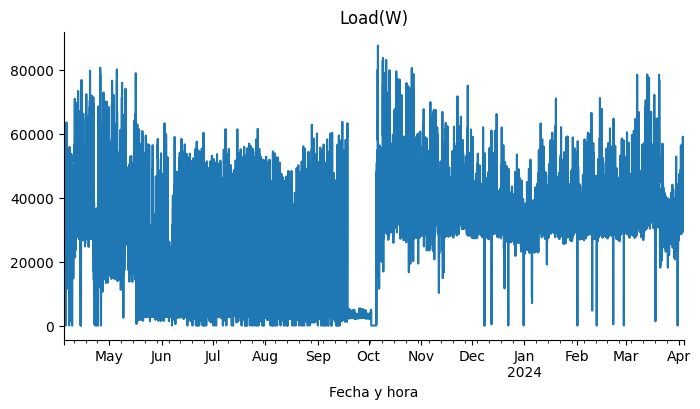

In [ ]:
from matplotlib import pyplot as plt
df['Load(W)'].plot(kind='line', figsize=(8, 4), title='Load(W)')
plt.gca().spines[['top', 'right']].set_visible(False)

Vista las gráficas que obtuvimos en la preparación de datos excluiremos los datos compredidos entre el periodo del 23 de septiembre de 2023 y el 5 de octubre de 2023, ya que estos datos no son representativos y podrían afectar negativamente la precisión de nuestro modelo.

In [ ]:
start_date = '2023-09-23'
end_date = '2023-10-05'

# Filtra el DataFrame para excluir el rango de fechas
df = df[(df.index < start_date) | (df.index > end_date)]

### 3.2. Preprocesamiento de datos

El preprocesamiento de los datos en este caso implica:
1. Eliminación de las columnas irrelevantes.
2. Generación del dataset supervisado: entrada y salida del modelo.
3. División de los datos en conjunto de entrenamiento y validación.
4. Escalar las variables predictoras para que tengan una media de 0 y una desviación estándar de 1, ayudando a la convergencia durante el entrenamiento del modelo.

#### 3.2.1. Eliminación de columnas irrelevantes

In [ ]:
df.pop('Humedad')
df.pop('Velocidad viento')
df

,Temperatura,Radiación,PV(W),Load(W)
Fecha y hora,,,,
2023-04-04 00:00:00,14.37,0.0,0.0,33387.333333
2023-04-04 00:30:00,14.20,0.0,0.0,23725.333333
2023-04-04 01:00:00,14.07,0.0,0.0,24043.833333
2023-04-04 01:30:00,14.23,0.0,0.0,23196.500000
2023-04-04 02:00:00,14.30,0.0,0.0,22820.833333
...,...,...,...,...
2024-04-03 22:00:00,15.17,0.0,0.0,35840.500000
2024-04-03 22:30:00,15.03,0.0,0.0,36835.500000
2024-04-03 23:00:00,14.63,0.0,0.0,31931.833333


#### 3.2.2. Generación del dataset y división del conjunto de datos en entrenamiento y validación

Prepararemos la serie temporal de los datos de acuerdo a lo especificado en la [documentación de las Redes LSTM en TensorFlow/Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).

Por otro lado, dividiremos nuestros datos en conjunto de entrenamiento y validación para poder evaluar la generalización del modelo. A diferencia de otros modelos de Machine Learning, en el caso de series temporales **se debe garantizar que se generan las divisiones sin mezclar aleatoriamente los datos**.

- El set de entrenamiento (train) se usará para encontrar los parámetros del modelo.
- El set de validación (val) para verificar que no haya under/over-fitting del modelo y para ajustar sus hiperparámetros.

De cada mes tomaremos los 22 primeros días para entrenar el modelo mientras que los últimos días de cada uno para validar.

In [ ]:
def crear_dataset_supervisado(dataframe, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.
    '''
    X_train, y_train = [], []  # Listados que contendrán los datos de entrada y salida del modelo para entrenamiento
    X_val, y_val = [], []  # Listados que contendrán los datos de entrada y salida del modelo para validar

    # Generar los arreglos
    for i in range(len(dataframe) - input_length - output_length + 1):
        X_temp = dataframe.iloc[i:(i + input_length), :]  # Tomar las filas correspondientes a las entradas
        y_temp = dataframe.iloc[(i + input_length):(i + input_length + output_length), 2]  # Tomar la columna correspondiente a la predicción

        # Extraer la fecha de la última muestra en el conjunto de entrada
        fecha_prediccion = pd.to_datetime(y_temp.index[0])
        dia_mes = fecha_prediccion.day

        if dia_mes <= 22:
            X_train.append(X_temp.values)
            y_train.append(y_temp.values)
        elif dia_mes >= 26:
            X_val.append(X_temp.values)
            y_val.append(y_temp.values)

    # Convertir listas a arreglos de NumPy
    X_train = np.array(X_train)
    y_train = np.array(y_train).reshape(-1, output_length, 1)  # Reshape para multi-step output
    X_val = np.array(X_val)
    y_val = np.array(y_val).reshape(-1, output_length, 1)  # Reshape para multi-step output

    return X_train, y_train, X_val, y_val

Inicialmente, proporcionaremos al modelo datos correspondientes a tres días para entrenarlo, con el objetivo de que realice predicciones sobre los datos de un día futuro.

In [ ]:
INPUT_LENGTH = 144  # Número de pasos de tiempo que el modelo utilizará para hacer predicciones
OUTPUT_LENGTH = 48  # Número de pasos de tiempo a predecir
x_tr, y_tr, x_val, y_val = crear_dataset_supervisado(df, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
print(f'Tamaño del set de entrenamiento: {y_tr.shape}')
print(f'Tamaño del set de validación: {y_val.shape}')

Tamaño del set de entrenamiento: (12289, 48, 1)
Tamaño del set de validación: (2928, 48, 1)


#### 3.2.3. Normalización de los datos

Escalamos cada una de las variables para que tengan una media de 0 y una desviación estándar de 1, ayudando a la convergencia durante el entrenamiento del modelo.

In [ ]:
from sklearn.preprocessing import StandardScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset para tener una media de 0 y desviación estándar de 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'x_ts':x_ts, 'y_ts':y_ts})
    - col_ref_idx: índice de la columna que contiene la variable a predecir

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # Determinar el índice de la columna que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [StandardScaler() for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros_like(data_input['x_tr'])
    x_val_s = np.zeros_like(data_input['x_val'])
    y_tr_s = np.zeros_like(data_input['y_tr'])
    y_val_s = np.zeros_like(data_input['y_val'])


    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_val_s[:,:,i] = scalers[i].transform(x_val[:,:,i])

    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_val_s[:,:,0] = scalers[col_ref].transform(y_val[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_val_s': x_val_s, 'y_val_s': y_val_s,
    }

    return data_scaled, scalers[col_ref]

In [ ]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_val': x_val, 'y_val': y_val,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'PV(W)' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_val_s, y_val_s = data_s['x_val_s'], data_s['y_val_s']

Graficamos para ver la distribución de cada una de las variables del modelo:

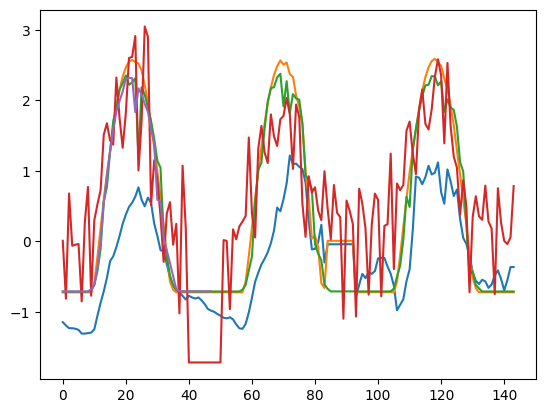

In [ ]:
plt.plot(x_val_s[100][:,0:4])
plt.plot(y_val_s[100][:])

### 4. Creación, entrenamiento y evaluación del modelo

- Entradas: arreglos *x* (batches x input-length  x features)
- Salidas: arreglos *y* (batches x output-length x features)

Usaremos la raíz cuadrada del error cuadrático medio (o RMSE por sus siglas en Inglés: *root mean square error*) como pérdida para entrenar el modelo:

$RMSE = \sqrt{\frac{\sum_i (y_i-\hat{y_i})^2}{N}}$

donde:
- $y$: generación fotovoltaica real
- $\hat{y}$: generación fotovoltaica predicha
- $N$: cantidad de predicciones


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def entrenar_modelo(x_train, y_train, x_val, y_val, optimizer='rmsprop', learning_rate=5e-4, n_units=128, input_shape=None, epochs=80, batch_size=256):
    """
    Entrena un modelo LSTM con los datos proporcionados y el optimizador elegido.

    Parámetros:
    x_train: Datos de entrenamiento.
    y_train: Etiquetas de entrenamiento.
    x_val: Datos de validación.
    y_val: Etiquetas de validación.
    optimizer: Nombre del optimizador a usar ('rmsprop' o 'adam').
    learning_rate: Tasa de aprendizaje para el optimizador.
    n_units: Número de unidades en la capa LSTM.
    input_shape: Forma de los datos de entrada.
    epochs: Número de épocas para el entrenamiento.
    batch_size: Tamaño del lote para el entrenamiento.

    Retorna:
    modelo: El modelo entrenado.
    historia: Registro del proceso de entrenamiento.
    """

    # Configurar reproducibilidad
    tf.random.set_seed(123)
    tf.config.experimental.enable_op_determinism()

    # Inicializar modelo
    modelo = Sequential()

    # Definir input_shape basado en x_train si no se proporciona
    if input_shape is None:
        input_shape = x_train.shape[1:]

    modelo.add(LSTM(n_units, input_shape=input_shape))
    modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))

    # Función de pérdida RMSE
    def root_mean_squared_error(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred - y_true)))

    # Seleccionar optimizador
    optimizador = {'rmsprop': RMSprop, 'adam': Adam}.get(optimizer, RMSprop)(learning_rate=learning_rate)

    # Compilar modelo
    modelo.compile(optimizer=optimizador, loss=root_mean_squared_error)

    # Callback para EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Entrenar modelo
    historia = modelo.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=2
    )

    return modelo, historia

#### 4.1. Comparación de Optimizadores

Evaluaremos el rendimiento de los optimizadores Adam y RMSprop manteniendo constantes el resto de los párametros del modelo con el objetivo de identificar cuál de estos optimizadores ofrece los mejores resultados en términos de presición y eficiencia.


##### 4.1.1. Optimizador Adam

Entrenaremos el modelo utilizando una única capa de 128 unidades con una tasa de aprendizaje de 0.0005. El entrenamiento se llevará a cabo durante 60 épocas con un tamaño de lote de 256.

In [ ]:
modelo, historia = entrenar_modelo(
    x_train=x_tr_s,
    y_train=y_tr_s,
    x_val=x_val_s,
    y_val=y_val_s,
    optimizer='adam',
    learning_rate=5e-4,
    n_units=128,
    input_shape=(x_tr_s.shape[1], x_tr_s.shape[2]),
    epochs=60,
    batch_size=256
)

Epoch 1/60
49/49 - 5s - loss: 0.7854 - val_loss: 0.5337 - 5s/epoch - 98ms/step
Epoch 2/60
49/49 - 1s - loss: 0.4913 - val_loss: 0.4792 - 612ms/epoch - 12ms/step
Epoch 3/60
49/49 - 1s - loss: 0.4541 - val_loss: 0.4300 - 617ms/epoch - 13ms/step
Epoch 4/60
49/49 - 1s - loss: 0.4337 - val_loss: 0.5577 - 600ms/epoch - 12ms/step
Epoch 5/60
49/49 - 1s - loss: 0.4521 - val_loss: 0.4080 - 606ms/epoch - 12ms/step
Epoch 6/60
49/49 - 1s - loss: 0.4157 - val_loss: 0.4089 - 610ms/epoch - 12ms/step
Epoch 7/60
49/49 - 1s - loss: 0.4084 - val_loss: 0.4057 - 610ms/epoch - 12ms/step
Epoch 8/60
49/49 - 1s - loss: 0.4052 - val_loss: 0.4024 - 616ms/epoch - 13ms/step
Epoch 9/60
49/49 - 1s - loss: 0.4047 - val_loss: 0.3962 - 618ms/epoch - 13ms/step
Epoch 10/60
49/49 - 1s - loss: 0.4026 - val_loss: 0.3876 - 612ms/epoch - 12ms/step
Epoch 11/60
49/49 - 1s - loss: 0.3972 - val_loss: 0.3816 - 714ms/epoch - 15ms/step
Epoch 12/60
49/49 - 1s - loss: 0.3969 - val_loss: 0.4322 - 650ms/epoch - 13ms/step
Epoch 13/60
49/4

A continuación, visualizamos la evolución del entrenamiento del modelo mostrando las pérdidas en el conjunto de entrenamiento y las pérdidas en el conjunto de validación.

Esto es fundamental para detectar si el modelo está sobreajustando los datos de entrenamiento o si generaliza bien.

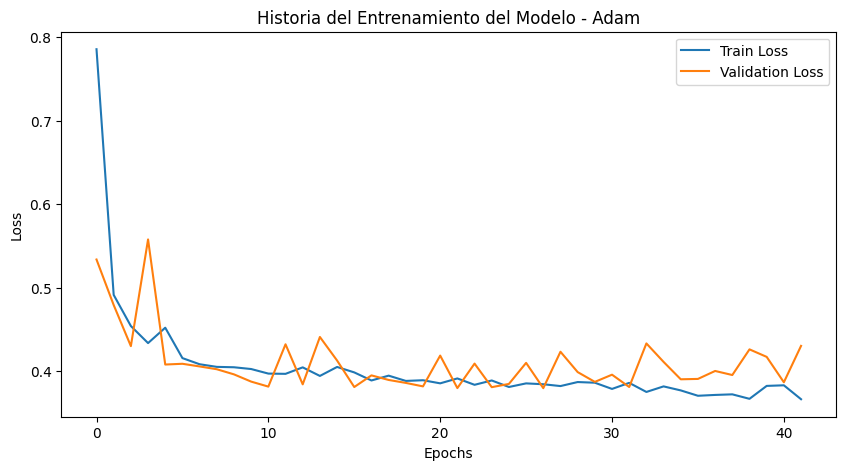

In [ ]:
import matplotlib.pyplot as plt

# Visualizar la historia de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(historia.history['loss'], label='Train Loss')
plt.plot(historia.history['val_loss'], label='Validation Loss')
plt.title('Historia del Entrenamiento del Modelo - Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluación del modelo**

Verificaremos el desempeño del modelo para el set de entrenamiento y validación empleando el optimizador Adam:

In [ ]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_val = modelo.evaluate(x=x_val_s, y=y_val_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE validation:\t {rmse_val:.3f}')

Comparativo desempeños:
  RMSE train:	 0.341
  RMSE validation:	 0.361


##### 4.1.2. Optimizador RMSprop

In [ ]:
modelo_rms, historia_rms = entrenar_modelo(
    x_train=x_tr_s,
    y_train=y_tr_s,
    x_val=x_val_s,
    y_val=y_val_s,
    optimizer='rmsprop',
    learning_rate=5e-4,
    n_units=128,
    input_shape=(x_tr_s.shape[1], x_tr_s.shape[2]),
    epochs=40,
    batch_size=256
)

Epoch 1/40
49/49 - 5s - loss: 0.7511 - val_loss: 0.5507 - 5s/epoch - 97ms/step
Epoch 2/40
49/49 - 1s - loss: 0.5420 - val_loss: 0.5053 - 612ms/epoch - 12ms/step
Epoch 3/40
49/49 - 1s - loss: 0.4968 - val_loss: 0.4704 - 614ms/epoch - 13ms/step
Epoch 4/40
49/49 - 1s - loss: 0.4777 - val_loss: 0.6054 - 609ms/epoch - 12ms/step
Epoch 5/40
49/49 - 1s - loss: 0.4647 - val_loss: 0.4507 - 613ms/epoch - 13ms/step
Epoch 6/40
49/49 - 1s - loss: 0.4520 - val_loss: 0.4280 - 602ms/epoch - 12ms/step
Epoch 7/40
49/49 - 1s - loss: 0.4424 - val_loss: 0.5959 - 618ms/epoch - 13ms/step
Epoch 8/40
49/49 - 1s - loss: 0.4350 - val_loss: 0.4778 - 656ms/epoch - 13ms/step
Epoch 9/40
49/49 - 1s - loss: 0.4299 - val_loss: 0.4661 - 661ms/epoch - 13ms/step
Epoch 10/40
49/49 - 1s - loss: 0.4249 - val_loss: 0.5435 - 662ms/epoch - 14ms/step
Epoch 11/40
49/49 - 1s - loss: 0.4227 - val_loss: 0.4782 - 678ms/epoch - 14ms/step
Epoch 12/40
49/49 - 1s - loss: 0.4187 - val_loss: 0.4850 - 640ms/epoch - 13ms/step
Epoch 13/40
49/4

Nuevamente representamos la evolución del entrenamiento del modelo

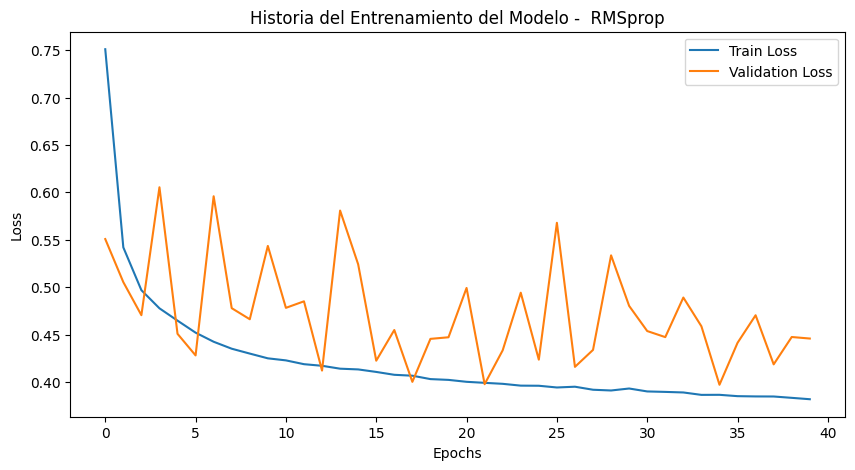

In [ ]:
# Visualizar la historia de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(historia_rms.history['loss'], label='Train Loss')
plt.plot(historia_rms.history['val_loss'], label='Validation Loss')
plt.title('Historia del Entrenamiento del Modelo -  RMSprop')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluación del modelo**

Verificaremos el desempeño del modelo para el set de entrenamiento y validación empleando el optimizador RMSprop:

In [ ]:
# Cálculo de rmses para train y val
rmse_tr = modelo_rms.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_val = modelo_rms.evaluate(x=x_val_s, y=y_val_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE validation:\t {rmse_val:.3f}')

Comparativo desempeños:
  RMSE train:	 0.410
  RMSE validation:	 0.424


#### 4.1.3. Comparación de rendimiento de optimizadores

Tras evaluar el desempeño de los dos optimizadores, Adam y RMSprop, se ha decidido seleccionar Adam como el optimizador principal por las siguientes razones:

1. **Menor Error Cuadrático Medio (RMSE):** Los resultados obtenidos muestran que Adam alcanza un RMSE de 0.341 en el conjunto de entrenamiento y de 0.361 en el conjunto de validación. Estos valores son considerablemente más bajos que los obtenidos con RMSprop, donde el RMSE fue de 0.410 en entrenamiento y de 0.424 en validación. Este mejor desempeño indica que Adam es más eficaz en minimizar la función de pérdida, resultando en predicciones más precisas.

2. **Optimización más Efectiva:** Adam combina las ventajas de otros dos métodos de optimización: AdaGrad y RMSProp. Al ajustar los coeficientes de aprendizaje de manera individual para diferentes parámetros y considerar el promedio de los gradientes pasados, Adam realiza ajustes más precisos, lo que puede ayudar a alcanzar el mínimo global de la función de pérdida más eficientemente.

### 4.2. Ajuste de Hiperparámetros

En esta fase del desarrollo, exploraremos diversas configuraciones de la arquitectura de la red para evaluar su impacto en el rendimiento del modelo. Inicialmente, utilizaremos una configuración con una sola capa que contiene 128 unidades. Posteriormente, procederemos a ajustar este parámetro disminuyendo el número de unidades para observar cómo afecta la eficacia del modelo. Además, experimentaremos con una arquitectura más compleja, añadiendo una segunda capa LSTM, con el objetivo de determinar si una mayor profundidad mejora la capacidad predictiva del modelo.

#### 4.2.1. Variante 1:

 Una capa LSTM de 128 unidades.

 Esta variante es la mostrada en el apartado anterior, donde se obtuvo un RMSE para el conjunto de entrenamiento de 0.341 y de 0.361 para el conjunto de validación.

**Evaluación gráfica de las predicciones del modelo**

Realizarenos una evaluación visual de las predicciones realizadas por el modelo para un día específico, utilizando el conjunto de validación. Para ello, primero realizaremos una función que nos devuelva la predicción en la escala original.

In [ ]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de dado
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)
    # y_pred = y_pred_s
    return y_pred.flatten()

In [ ]:
# Calcular predicciones sobre el set de validación
y_val_pred = predecir(x_val_s, modelo, scaler)

Realizamos un histograma que nos permita ver los errores que se cometen en la predicción y con que frecuencia.

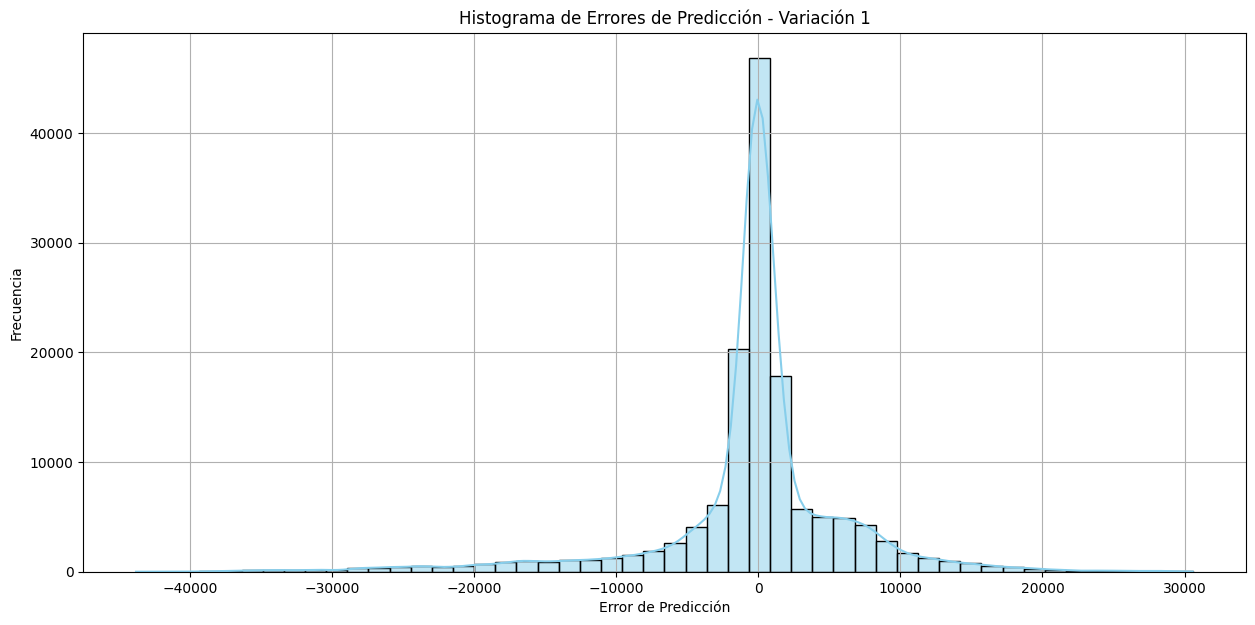

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Aplanar y_ts para que coincida con la forma de y_val_pred antes de calcular los errores
y_val_flat = y_val.flatten()

# Calcular errores
errores = y_val_flat - y_val_pred

# Graficar histograma de errores con curva de densidad
plt.figure(figsize=(15, 7))
sns.histplot(errores, bins=50, color='skyblue', kde=True)
plt.title('Histograma de Errores de Predicción - Variación 1')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Con el objetivo de evaluar la precisión de nuestro modelo, hemos comparado la generación fotovoltaica predicha con los datos reales correspondientes a un día específico. Esta comparación visual nos permite apreciar la efectividad del modelo en predecir con exactitud la generación fotovoltaica, proporcionando una medida clara de su rendimiento.

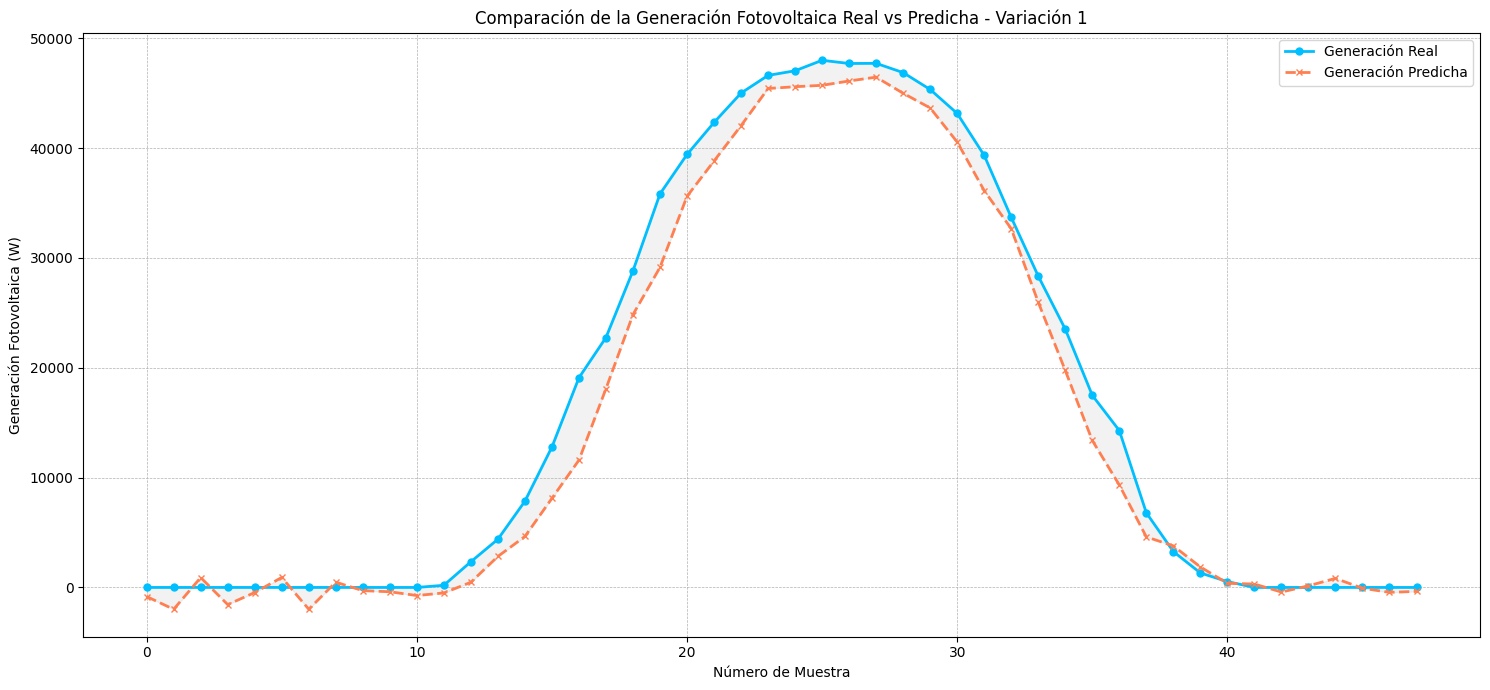

In [ ]:
y_val_flat_one_day = y_val_flat[30000:30048]
y_val_pred_one_day = y_val_pred[30000:30048]
num_muestras_one_day = np.arange(48)  # 48 muestras tiene un día

# Graficar la generación fotovoltaica real frente a la predicha para un día
plt.figure(figsize=(15, 7))
plt.plot(num_muestras_one_day, y_val_flat_one_day, label='Generación Real', color='deepskyblue', linewidth=2, marker='o', markersize=5)
plt.plot(num_muestras_one_day, y_val_pred_one_day, label='Generación Predicha', color='coral', linewidth=2, linestyle='--', marker='x', markersize=5)
plt.fill_between(num_muestras_one_day, y_val_flat_one_day, y_val_pred_one_day, color='grey', alpha=0.1)

plt.title('Comparación de la Generación Fotovoltaica Real vs Predicha - Variación 1')
plt.xlabel('Número de Muestra')
plt.ylabel('Generación Fotovoltaica (W)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### 4.2.2. Variante 2:

 Una capa de 64 unidades

In [ ]:
modelo2, historia2 = entrenar_modelo(
    x_train=x_tr_s,
    y_train=y_tr_s,
    x_val=x_val_s,
    y_val=y_val_s,
    optimizer='adam',
    learning_rate=5e-4,
    n_units=64,
    input_shape=(x_tr_s.shape[1], x_tr_s.shape[2]),
    epochs=60,
    batch_size=256
)

Epoch 1/60
49/49 - 4s - loss: 0.9332 - val_loss: 0.7903 - 4s/epoch - 90ms/step
Epoch 2/60
49/49 - 1s - loss: 0.6730 - val_loss: 0.5429 - 672ms/epoch - 14ms/step
Epoch 3/60
49/49 - 1s - loss: 0.5174 - val_loss: 0.4727 - 682ms/epoch - 14ms/step
Epoch 4/60
49/49 - 1s - loss: 0.4623 - val_loss: 0.4955 - 719ms/epoch - 15ms/step
Epoch 5/60
49/49 - 1s - loss: 0.4558 - val_loss: 0.4278 - 728ms/epoch - 15ms/step
Epoch 6/60
49/49 - 1s - loss: 0.4303 - val_loss: 0.4247 - 692ms/epoch - 14ms/step
Epoch 7/60
49/49 - 1s - loss: 0.4222 - val_loss: 0.4100 - 1s/epoch - 24ms/step
Epoch 8/60
49/49 - 1s - loss: 0.4154 - val_loss: 0.4259 - 922ms/epoch - 19ms/step
Epoch 9/60
49/49 - 0s - loss: 0.4135 - val_loss: 0.4068 - 449ms/epoch - 9ms/step
Epoch 10/60
49/49 - 0s - loss: 0.4113 - val_loss: 0.4024 - 414ms/epoch - 8ms/step
Epoch 11/60
49/49 - 0s - loss: 0.4041 - val_loss: 0.3975 - 398ms/epoch - 8ms/step
Epoch 12/60
49/49 - 0s - loss: 0.4037 - val_loss: 0.4072 - 410ms/epoch - 8ms/step
Epoch 13/60
49/49 - 0s 

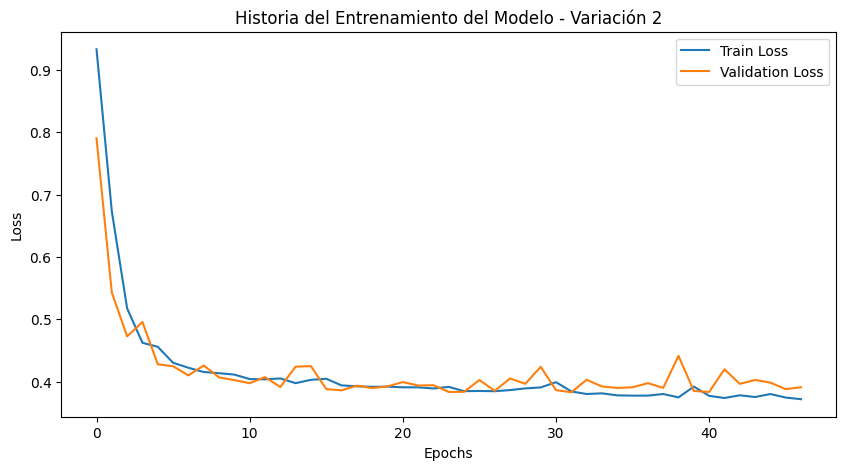

In [ ]:
# Visualizar la historia de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(historia2.history['loss'], label='Train Loss')
plt.plot(historia2.history['val_loss'], label='Validation Loss')
plt.title('Historia del Entrenamiento del Modelo - Variación 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Cálculo de rmses para train y val
rmse_tr = modelo2.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_val = modelo2.evaluate(x=x_val_s, y=y_val_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños - Variación 2:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE validation:\t {rmse_val:.3f}')

Comparativo desempeños - Variación 2:
  RMSE train:	 0.347
  RMSE validation:	 0.365


Comparando los RMSE, podemos observar lo siguiente:

- RMSE de entrenamiento (train): Ha aumentado ligeramente de 0.341 a 0.347. Esto indica que el modelo con una única capa de 64 unidades tiene un desempeño ligeramente peor en el conjunto de entrenamiento comparado con la configuración anterior.
- RMSE de validación (validation): También ha aumentado, de 0.361 a 0.365. Esto sugiere que el modelo es ligeramente menos preciso en el conjunto de validación con la nueva configuración.

In [ ]:
# Calcular predicciones sobre el set de validación
y_val_pred = predecir(x_val_s, modelo2, scaler)

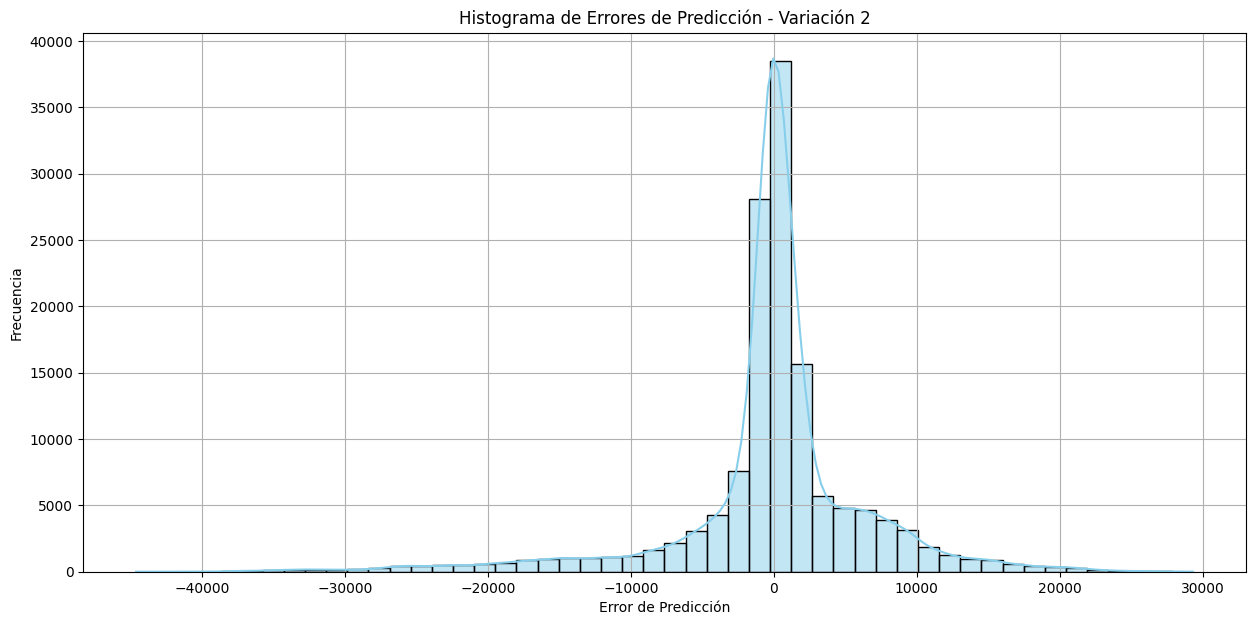

In [ ]:
# Aplanar y_ts para que coincida con la forma de y_val_pred antes de calcular los errores
y_val_flat = y_val.flatten()

# Calcular errores
errores = y_val_flat - y_val_pred

# Graficar histograma de errores con curva de densidad
plt.figure(figsize=(15, 7))
sns.histplot(errores, bins=50, color='skyblue', kde=True)
plt.title('Histograma de Errores de Predicción - Variación 2')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

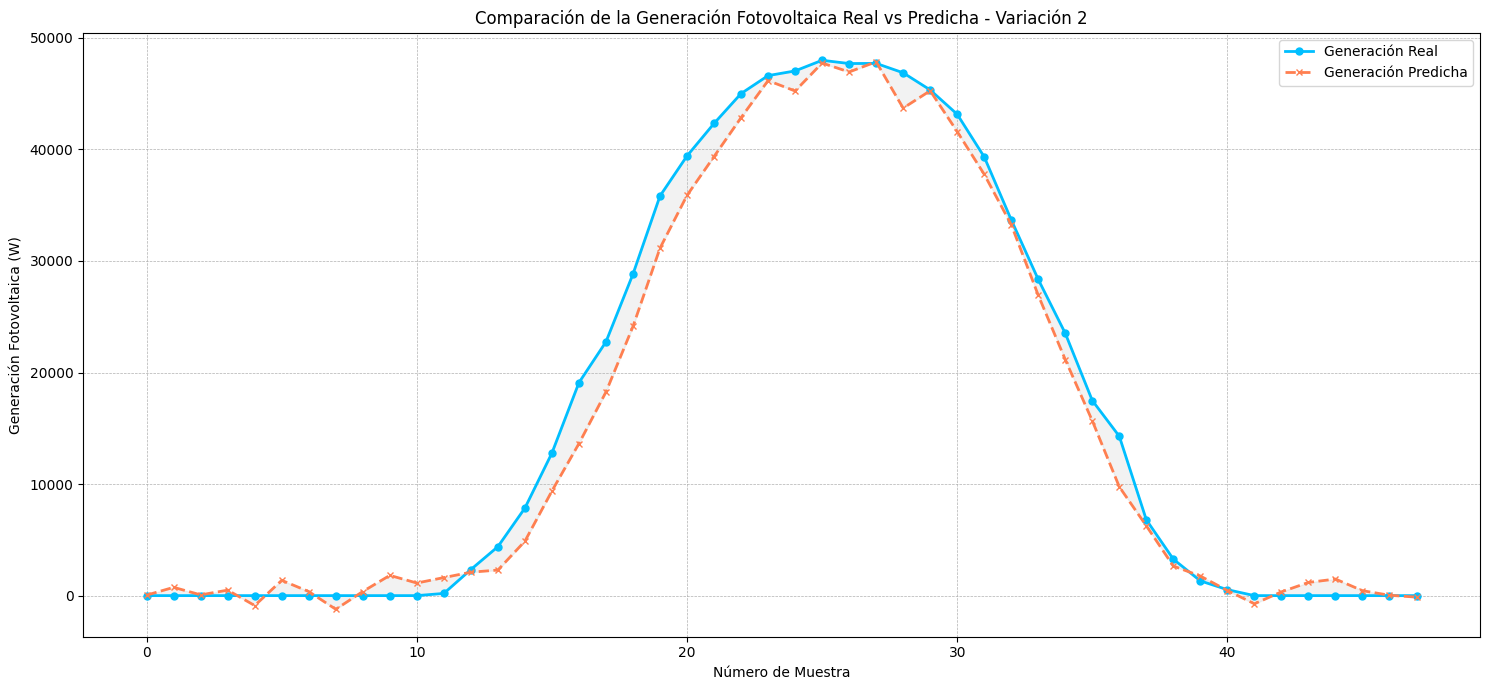

In [ ]:
y_val_flat_one_day = y_val_flat[30000:30048]
y_val_pred_one_day = y_val_pred[30000:30048]
num_muestras_one_day = np.arange(48)  # 48 muestras tiene un día

# Graficar la generación fotovoltaica real frente a la predicha para un día
plt.figure(figsize=(15, 7))
plt.plot(num_muestras_one_day, y_val_flat_one_day, label='Generación Real', color='deepskyblue', linewidth=2, marker='o', markersize=5)
plt.plot(num_muestras_one_day, y_val_pred_one_day, label='Generación Predicha', color='coral', linewidth=2, linestyle='--', marker='x', markersize=5)
plt.fill_between(num_muestras_one_day, y_val_flat_one_day, y_val_pred_one_day, color='grey', alpha=0.1)

plt.title('Comparación de la Generación Fotovoltaica Real vs Predicha - Variación 2')
plt.xlabel('Número de Muestra')
plt.ylabel('Generación Fotovoltaica (W)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Los nuevos resultados con una capa de 64 unidades no son mejores que los anteriores. De hecho, muestran un ligero deterioro tanto en el entrenamiento como en la validación. Esto podría deberse a que la reducción en la cantidad de unidades ha limitado la capacidad del modelo para capturar la complejidad de los datos.

#### 4.2.3. Variante 3:

  1ª Capa de 128 unidades

  2ª Capa de 64 unidades

Primero creamos una función que nos permita entrenar un modelo que contenga dos capas LSTM:

In [ ]:
import tensorflow as tf

def entrenar_modelo_2capas(x_train, y_train, x_val, y_val, optimizer='rmsprop', learning_rate=5e-4, n_units1=128, n_units2=64, input_shape=None, epochs=80, batch_size=256):
    """
    Entrena un modelo LSTM con dos capas LSTM de diferentes tamaños utilizando los datos proporcionados y el optimizador elegido.

    Parámetros:
    x_train: Datos de entrenamiento.
    y_train: Etiquetas de entrenamiento.
    x_val: Datos de validación.
    y_val: Etiquetas de validación.
    optimizer: Nombre del optimizador a usar ('rmsprop' o 'adam').
    learning_rate: Tasa de aprendizaje para el optimizador.
    n_units1: Número de unidades en la primera capa LSTM.
    n_units2: Número de unidades en la segunda capa LSTM.
    input_shape: Forma de los datos de entrada.
    epochs: Número de épocas para el entrenamiento.
    batch_size: Tamaño del lote para el entrenamiento.

    Retorna:
    modelo: El modelo entrenado.
    historia: Registro del proceso de entrenamiento.
    """

    # Configurar reproducibilidad
    tf.random.set_seed(123)
    tf.config.experimental.enable_op_determinism()

    # Inicializar modelo
    modelo = Sequential()

    # Definir input_shape basado en x_train si no se proporciona
    if input_shape is None:
        input_shape = x_train.shape[1:]

    # Primera capa LSTM con retorno de secuencias
    modelo.add(LSTM(n_units1, input_shape=input_shape, return_sequences=True))
    # Segunda capa LSTM
    modelo.add(LSTM(n_units2))
    modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))

    # Función de pérdida RMSE
    def root_mean_squared_error(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred - y_true)))

    # Seleccionar optimizador
    optimizador = {'rmsprop': RMSprop, 'adam': Adam}.get(optimizer, RMSprop)(learning_rate=learning_rate)

    # Compilar modelo
    modelo.compile(optimizer=optimizador, loss=root_mean_squared_error)

    # Callback para EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Entrenar modelo
    historia = modelo.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=2
    )

    return modelo, historia


In [ ]:
modelo3, historia3 = entrenar_modelo_2capas(
    x_train=x_tr_s,
    y_train=y_tr_s,
    x_val=x_val_s,
    y_val=y_val_s,
    optimizer='adam',
    learning_rate=5e-4,
    n_units1=128,
    n_units2=64,
    input_shape=(x_tr_s.shape[1], x_tr_s.shape[2]),
    epochs=60,
    batch_size=256
)

Epoch 1/60
49/49 - 5s - loss: 0.7811 - val_loss: 0.5494 - 5s/epoch - 95ms/step
Epoch 2/60
49/49 - 1s - loss: 0.5019 - val_loss: 0.4742 - 1s/epoch - 21ms/step
Epoch 3/60
49/49 - 1s - loss: 0.4516 - val_loss: 0.4302 - 1s/epoch - 20ms/step
Epoch 4/60
49/49 - 1s - loss: 0.4251 - val_loss: 0.5227 - 1s/epoch - 21ms/step
Epoch 5/60
49/49 - 1s - loss: 0.4359 - val_loss: 0.4045 - 1s/epoch - 21ms/step
Epoch 6/60
49/49 - 1s - loss: 0.4075 - val_loss: 0.4192 - 1s/epoch - 22ms/step
Epoch 7/60
49/49 - 1s - loss: 0.4069 - val_loss: 0.3980 - 1s/epoch - 20ms/step
Epoch 8/60
49/49 - 1s - loss: 0.3998 - val_loss: 0.4273 - 1s/epoch - 22ms/step
Epoch 9/60
49/49 - 1s - loss: 0.4065 - val_loss: 0.3964 - 1s/epoch - 21ms/step
Epoch 10/60
49/49 - 1s - loss: 0.3978 - val_loss: 0.3990 - 1s/epoch - 21ms/step
Epoch 11/60
49/49 - 1s - loss: 0.3970 - val_loss: 0.3886 - 1s/epoch - 21ms/step
Epoch 12/60
49/49 - 1s - loss: 0.3892 - val_loss: 0.4041 - 1s/epoch - 22ms/step
Epoch 13/60
49/49 - 1s - loss: 0.3937 - val_loss:

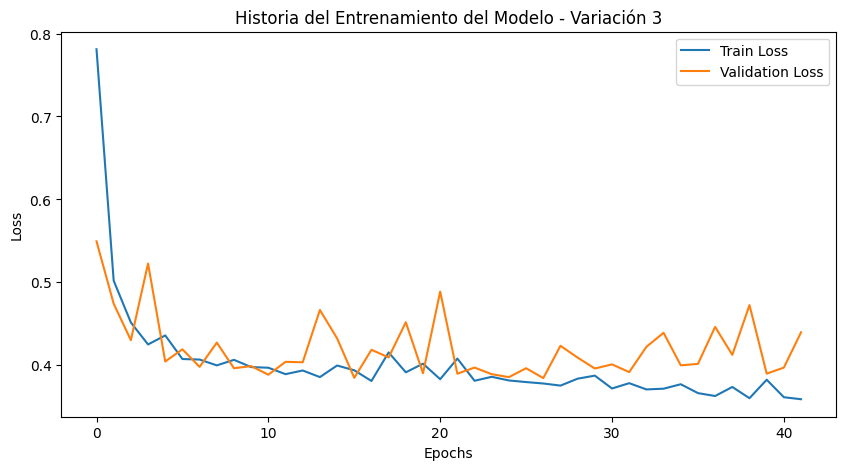

In [ ]:
# Visualizar la historia de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(historia3.history['loss'], label='Train Loss')
plt.plot(historia3.history['val_loss'], label='Validation Loss')
plt.title('Historia del Entrenamiento del Modelo - Variación 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Cálculo de rmses para train y val
rmse_tr = modelo3.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_val = modelo3.evaluate(x=x_val_s, y=y_val_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños - Variación 3:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE validation:\t {rmse_val:.3f}')

Comparativo desempeños - Variación 3:
  RMSE train:	 0.341
  RMSE validation:	 0.366


En este caso, respecto a la primera configuración, el RMSE de entrenamiento (train) Se mantuvo constante en 0.341 en ambas configuraciones. Esto indica que la capacidad del modelo para ajustarse a los datos de entrenamiento no se ha visto afectada por el aumento en la complejidad del modelo.

Sin embargo, el RMSE de validación ha aumentado ligeramente de 0.361 a 0.366 con la nueva configuración de dos capas.

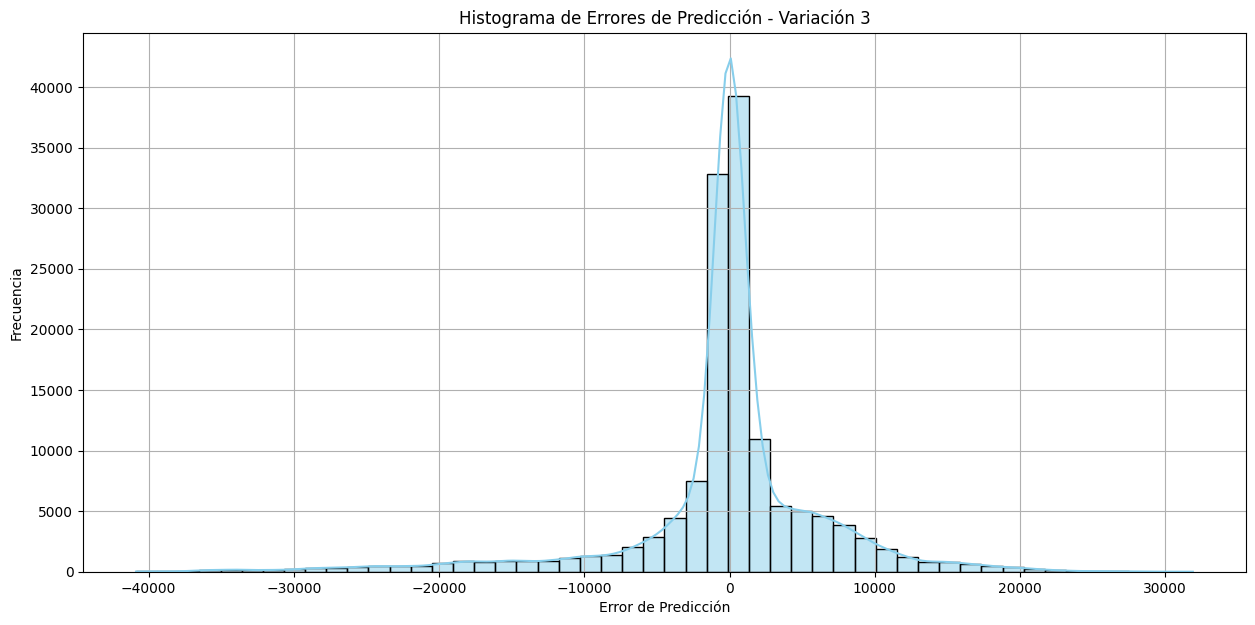

In [ ]:
# Calcular predicciones sobre el set de validación
y_val_pred = predecir(x_val_s, modelo3, scaler)

# Aplanar y_ts para que coincida con la forma de y_val_pred antes de calcular los errores
y_val_flat = y_val.flatten()

# Calcular errores
errores = y_val_flat - y_val_pred

# Graficar histograma de errores con curva de densidad
plt.figure(figsize=(15, 7))
sns.histplot(errores, bins=50, color='skyblue', kde=True)
plt.title('Histograma de Errores de Predicción - Variación 3')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

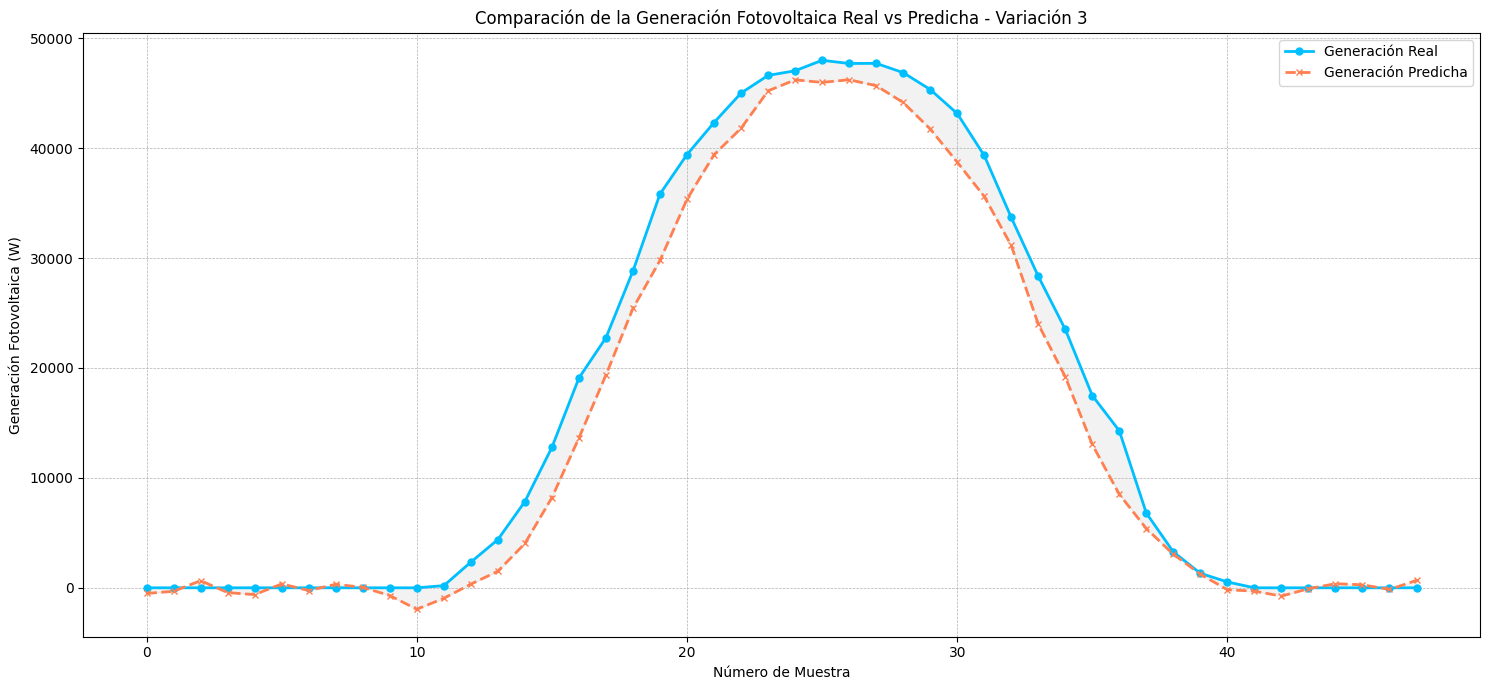

In [ ]:
y_val_flat_one_day = y_val_flat[30000:30048]
y_val_pred_one_day = y_val_pred[30000:30048]
num_muestras_one_day = np.arange(48)  # 48 muestras tiene un día

# Graficar la generación fotovoltaica real frente a la predicha para un día
plt.figure(figsize=(15, 7))
plt.plot(num_muestras_one_day, y_val_flat_one_day, label='Generación Real', color='deepskyblue', linewidth=2, marker='o', markersize=5)
plt.plot(num_muestras_one_day, y_val_pred_one_day, label='Generación Predicha', color='coral', linewidth=2, linestyle='--', marker='x', markersize=5)
plt.fill_between(num_muestras_one_day, y_val_flat_one_day, y_val_pred_one_day, color='grey', alpha=0.1)

plt.title('Comparación de la Generación Fotovoltaica Real vs Predicha - Variación 3')
plt.xlabel('Número de Muestra')
plt.ylabel('Generación Fotovoltaica (W)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

La adición de una segunda capa LSTM tampoco ha mejorado el rendimiento del modelo en términos de RMSE de validación, aunque el desempeño es prácticamente idéntico, por ello, se decide optar por una estructura más simple utilizando una única capa LSTM en lugar de dos.

### 5. Impacto de las variables de entrada

#### 5.1. Introducción de las horas del día como variable de entrada

Para ello, primero extraeremos la hora del día de la columna fecha (índice de nuestro dataframe). Acto seguido, aplicaremos una codificación cíclica a la hora del día. Esta se realiza transformando la hora del día a dos dimensiones usando funciones seno y coseno para mantener la naturaleza cíclica de las horas.

In [ ]:
# Extraemos la hora del índice
df['Hora'] = df.index.hour

# Aplicar codificación cíclica
df['Hora_sin'] = np.sin(df['Hora'] * (2. * np.pi / 24))
df['Hora_cos'] = np.cos(df['Hora'] * (2. * np.pi / 24))

# Ahora, el df incluye las nuevas columnas 'Hora_sin' y 'Hora_cos' que
# incluiremos como variables de entrada para el modelo LSTM
print(df.columns)

Index(['Temperatura', 'Humedad', 'Velocidad viento', 'Radiación', 'PV(W)',
       'Load(W)', 'Hora', 'Hora_sin', 'Hora_cos'],
      dtype='object')


<ipython-input-8-aaebe5cf6208>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hora'] = df.index.hour
<ipython-input-8-aaebe5cf6208>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hora_sin'] = np.sin(df['Hora'] * (2. * np.pi / 24))
<ipython-input-8-aaebe5cf6208>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [ ]:
df

,Temperatura,Humedad,Velocidad viento,Radiación,PV(W),Load(W),Hora,Hora_sin,Hora_cos
Fecha y hora,,,,,,,,,
2023-04-04 00:00:00,14.37,85.87,7.33,0.0,0.0,33387.333333,0,0.000000,1.000000
2023-04-04 00:30:00,14.20,91.20,8.10,0.0,0.0,23725.333333,0,0.000000,1.000000
2023-04-04 01:00:00,14.07,92.03,7.90,0.0,0.0,24043.833333,1,0.258819,0.965926
2023-04-04 01:30:00,14.23,91.57,7.40,0.0,0.0,23196.500000,1,0.258819,0.965926
2023-04-04 02:00:00,14.30,86.63,7.13,0.0,0.0,22820.833333,2,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...
2024-04-03 22:00:00,15.17,84.07,2.33,0.0,0.0,35840.500000,22,-0.500000,0.866025
2024-04-03 22:30:00,15.03,83.43,2.20,0.0,0.0,36835.500000,22,-0.500000,0.866025
2024-04-03 23:00:00,14.63,86.87,2.30,0.0,0.0,31931.833333,23,-0.258819,0.965926


Eliminamos la columna hora

In [ ]:
df.pop('Hora')

Fecha y hora
2023-04-04 00:00:00     0
2023-04-04 00:30:00     0
2023-04-04 01:00:00     1
2023-04-04 01:30:00     1
2023-04-04 02:00:00     2
                       ..
2024-04-03 22:00:00    22
2024-04-03 22:30:00    22
2024-04-03 23:00:00    23
2024-04-03 23:30:00    23
2024-04-04 00:00:00     0
Name: Hora, Length: 16992, dtype: int32

Volvemos a preparar el dataset y dividir el conjunto de datos en entrenamiento y validación ya que hemos añadido una nueva variable predictora:

In [ ]:
INPUT_LENGTH = 144  # Número de pasos de tiempo que el modelo utilizará para hacer predicciones
OUTPUT_LENGTH = 48  # Número de pasos de tiempo a predecir
x_tr, y_tr, x_val, y_val = crear_dataset_supervisado(df, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
print(f'Tamaño del set de entrenamiento de entrada: {x_tr.shape}')
print(f'Tamaño del set de validación de entrada: {x_val.shape}')

Tamaño del set de entrenamiento de entrada: (12289, 144, 6)
Tamaño del set de validación de entrada: (2928, 144, 6)


Volvemos a escalar los datos ya que hemos añadido a nuestro modelo, hora_sin y hora_cos.

In [ ]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_val': x_val, 'y_val': y_val,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'PV(W)' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_val_s, y_val_s = data_s['x_val_s'], data_s['y_val_s']

Volvemos a entrenar el modelo empleando la mejor configuración de hiperparámetros

In [ ]:
modelo_h, historia_h = entrenar_modelo(
    x_train=x_tr_s,
    y_train=y_tr_s,
    x_val=x_val_s,
    y_val=y_val_s,
    optimizer='adam',
    learning_rate=5e-4,
    n_units=128,
    input_shape=(x_tr_s.shape[1], x_tr_s.shape[2]),
    epochs=60,
    batch_size=256
)

Epoch 1/60
49/49 - 3s - loss: 0.7414 - val_loss: 0.4959 - 3s/epoch - 62ms/step
Epoch 2/60
49/49 - 1s - loss: 0.4739 - val_loss: 0.4504 - 674ms/epoch - 14ms/step
Epoch 3/60
49/49 - 1s - loss: 0.4407 - val_loss: 0.4152 - 667ms/epoch - 14ms/step
Epoch 4/60
49/49 - 1s - loss: 0.4180 - val_loss: 0.4306 - 660ms/epoch - 13ms/step
Epoch 5/60
49/49 - 1s - loss: 0.4121 - val_loss: 0.3920 - 614ms/epoch - 13ms/step
Epoch 6/60
49/49 - 1s - loss: 0.3997 - val_loss: 0.4077 - 611ms/epoch - 12ms/step
Epoch 7/60
49/49 - 1s - loss: 0.3989 - val_loss: 0.3973 - 607ms/epoch - 12ms/step
Epoch 8/60
49/49 - 1s - loss: 0.3947 - val_loss: 0.3983 - 610ms/epoch - 12ms/step
Epoch 9/60
49/49 - 1s - loss: 0.3933 - val_loss: 0.3867 - 613ms/epoch - 13ms/step
Epoch 10/60
49/49 - 1s - loss: 0.3900 - val_loss: 0.3960 - 609ms/epoch - 12ms/step
Epoch 11/60
49/49 - 1s - loss: 0.3908 - val_loss: 0.3927 - 615ms/epoch - 13ms/step
Epoch 12/60
49/49 - 1s - loss: 0.3873 - val_loss: 0.4087 - 614ms/epoch - 13ms/step
Epoch 13/60
49/4

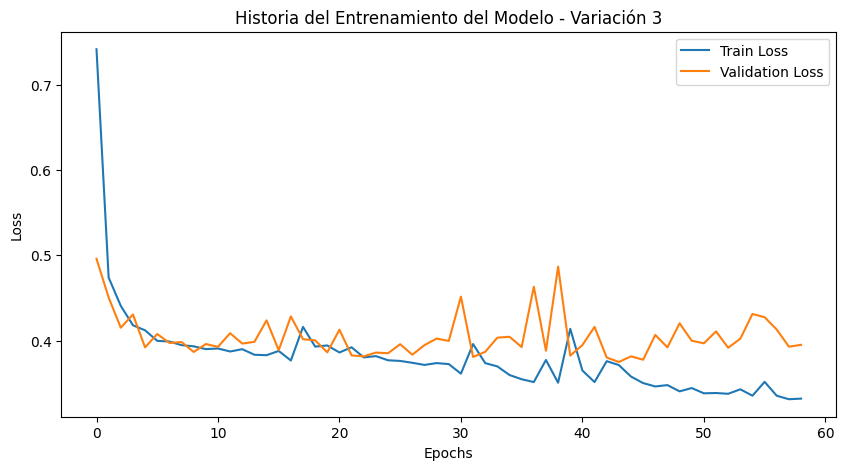

In [ ]:
# Visualizar la historia de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(historia_h.history['loss'], label='Train Loss')
plt.plot(historia_h.history['val_loss'], label='Validation Loss')
plt.title('Historia del Entrenamiento del Modelo - Variación 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Cálculo de rmses para train y val
rmse_tr = modelo_h.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_val = modelo_h.evaluate(x=x_val_s, y=y_val_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños - Implementación hora del día:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE validation:\t {rmse_val:.3f}')

Comparativo desempeños - Implementación hora del día:
  RMSE train:	 0.332
  RMSE validation:	 0.360


Tras añadir la hora del día como variable predictiva en nuestro modelo, los resultados han mejorado, aunque tampoco de forma significativa. El RMSE para el conjunto de entrenamiento ha disminuido de 0.341 a 0.332 mientras que el RMSE en el conjunto de validación se ha mantenido prácticamente estable.

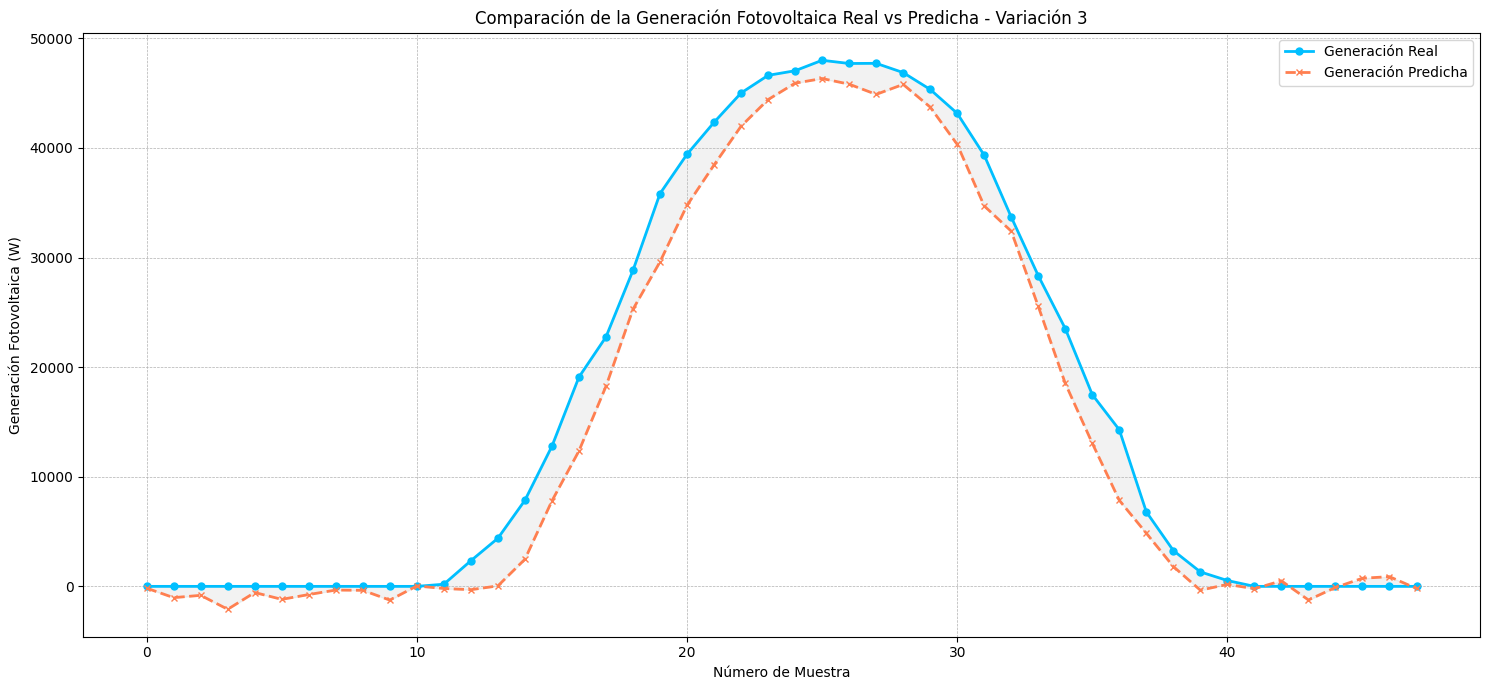

In [ ]:
# Calcular predicciones sobre el set de validación
y_val_pred = predecir(x_val_s, modelo_h, scaler)

# Aplanar y_ts para que coincida con la forma de y_val_pred
y_val_flat = y_val.flatten()

y_val_flat_one_day = y_val_flat[30000:30048]
y_val_pred_one_day = y_val_pred[30000:30048]
num_muestras_one_day = np.arange(48)  # 48 muestras tiene un día

# Graficar la generación fotovoltaica real frente a la predicha para un día
plt.figure(figsize=(15, 7))
plt.plot(num_muestras_one_day, y_val_flat_one_day, label='Generación Real', color='deepskyblue', linewidth=2, marker='o', markersize=5)
plt.plot(num_muestras_one_day, y_val_pred_one_day, label='Generación Predicha', color='coral', linewidth=2, linestyle='--', marker='x', markersize=5)
plt.fill_between(num_muestras_one_day, y_val_flat_one_day, y_val_pred_one_day, color='grey', alpha=0.1)

plt.title('Comparación de la Generación Fotovoltaica Real vs Predicha - Variación 3')
plt.xlabel('Número de Muestra')
plt.ylabel('Generación Fotovoltaica (W)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### 5.2. Modelo entrenado con entrada de consumo vs sin entrada de consumo

In [ ]:
df.pop('Load(W)')

Fecha y hora
2023-04-04 00:00:00    33387.333333
2023-04-04 00:30:00    23725.333333
2023-04-04 01:00:00    24043.833333
2023-04-04 01:30:00    23196.500000
2023-04-04 02:00:00    22820.833333
                           ...     
2024-04-03 22:00:00    35840.500000
2024-04-03 22:30:00    36835.500000
2024-04-03 23:00:00    31931.833333
2024-04-03 23:30:00    42926.333333
2024-04-04 00:00:00    30435.666667
Name: Load(W), Length: 16992, dtype: float64

In [ ]:
df

,Temperatura,Radiación,PV(W),Hora_sin,Hora_cos
Fecha y hora,,,,,
2023-04-04 00:00:00,14.37,0.0,0.0,0.000000,1.000000
2023-04-04 00:30:00,14.20,0.0,0.0,0.000000,1.000000
2023-04-04 01:00:00,14.07,0.0,0.0,0.258819,0.965926
2023-04-04 01:30:00,14.23,0.0,0.0,0.258819,0.965926
2023-04-04 02:00:00,14.30,0.0,0.0,0.500000,0.866025
...,...,...,...,...,...
2024-04-03 22:00:00,15.17,0.0,0.0,-0.500000,0.866025
2024-04-03 22:30:00,15.03,0.0,0.0,-0.500000,0.866025
2024-04-03 23:00:00,14.63,0.0,0.0,-0.258819,0.965926


Preparamos el dataset ya que ahora contamos con una variable predictora menos.

In [ ]:
INPUT_LENGTH = 144  # Número de pasos de tiempo que el modelo utilizará para hacer predicciones
OUTPUT_LENGTH = 48  # Número de pasos de tiempo a predecir
x_tr, y_tr, x_val, y_val = crear_dataset_supervisado(df, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
print(f'Tamaño del set de entrenamiento: {x_tr.shape}')
print(f'Tamaño del set de validación: {x_val.shape}')

Tamaño del set de entrenamiento: (12289, 144, 5)
Tamaño del set de validación: (2928, 144, 5)


Volvemos a entrenar el modelo

In [ ]:
modelo_load, historia_load = entrenar_modelo(
    x_train=x_tr_s,
    y_train=y_tr_s,
    x_val=x_val_s,
    y_val=y_val_s,
    optimizer='adam',
    learning_rate=5e-4,
    n_units=128,
    input_shape=(x_tr_s.shape[1], x_tr_s.shape[2]),
    epochs=60,
    batch_size=256
)

Epoch 1/60
49/49 - 4s - loss: 0.7679 - val_loss: 0.4985 - 4s/epoch - 74ms/step
Epoch 2/60
49/49 - 1s - loss: 0.4753 - val_loss: 0.4427 - 609ms/epoch - 12ms/step
Epoch 3/60
49/49 - 1s - loss: 0.4424 - val_loss: 0.4316 - 611ms/epoch - 12ms/step
Epoch 4/60
49/49 - 1s - loss: 0.4217 - val_loss: 0.4082 - 610ms/epoch - 12ms/step
Epoch 5/60
49/49 - 1s - loss: 0.4111 - val_loss: 0.3830 - 605ms/epoch - 12ms/step
Epoch 6/60
49/49 - 1s - loss: 0.3995 - val_loss: 0.3910 - 611ms/epoch - 12ms/step
Epoch 7/60
49/49 - 1s - loss: 0.3990 - val_loss: 0.3923 - 609ms/epoch - 12ms/step
Epoch 8/60
49/49 - 1s - loss: 0.3953 - val_loss: 0.3918 - 604ms/epoch - 12ms/step
Epoch 9/60
49/49 - 1s - loss: 0.3929 - val_loss: 0.3823 - 689ms/epoch - 14ms/step
Epoch 10/60
49/49 - 1s - loss: 0.3938 - val_loss: 0.3823 - 608ms/epoch - 12ms/step
Epoch 11/60
49/49 - 1s - loss: 0.3884 - val_loss: 0.3822 - 614ms/epoch - 13ms/step
Epoch 12/60
49/49 - 1s - loss: 0.3861 - val_loss: 0.4132 - 607ms/epoch - 12ms/step
Epoch 13/60
49/4

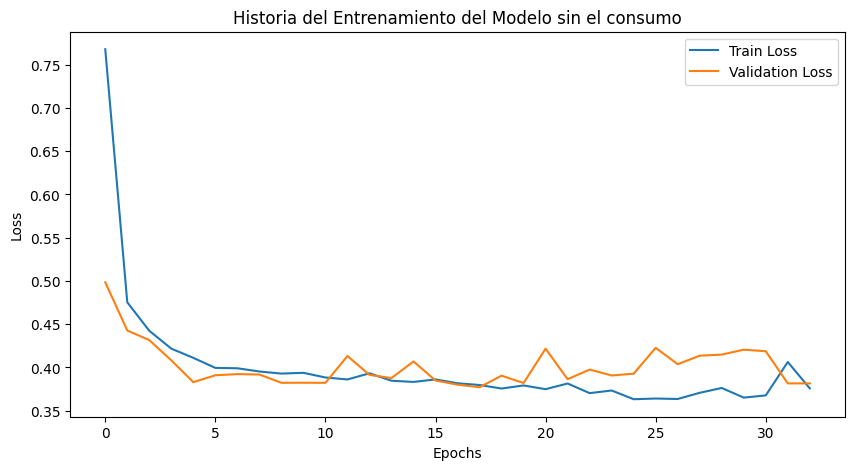

In [ ]:
# Visualizar la historia de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(historia_load.history['loss'], label='Train Loss')
plt.plot(historia_load.history['val_loss'], label='Validation Loss')
plt.title('Historia del Entrenamiento del Modelo sin el consumo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Cálculo de rmses para train y val
rmse_tr = modelo_load.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_val = modelo_load.evaluate(x=x_val_s, y=y_val_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños - Sin Consumo:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE validation:\t {rmse_val:.3f}')

Comparativo desempeños - Sin Consumo:
  RMSE train:	 0.342
  RMSE validation:	 0.362


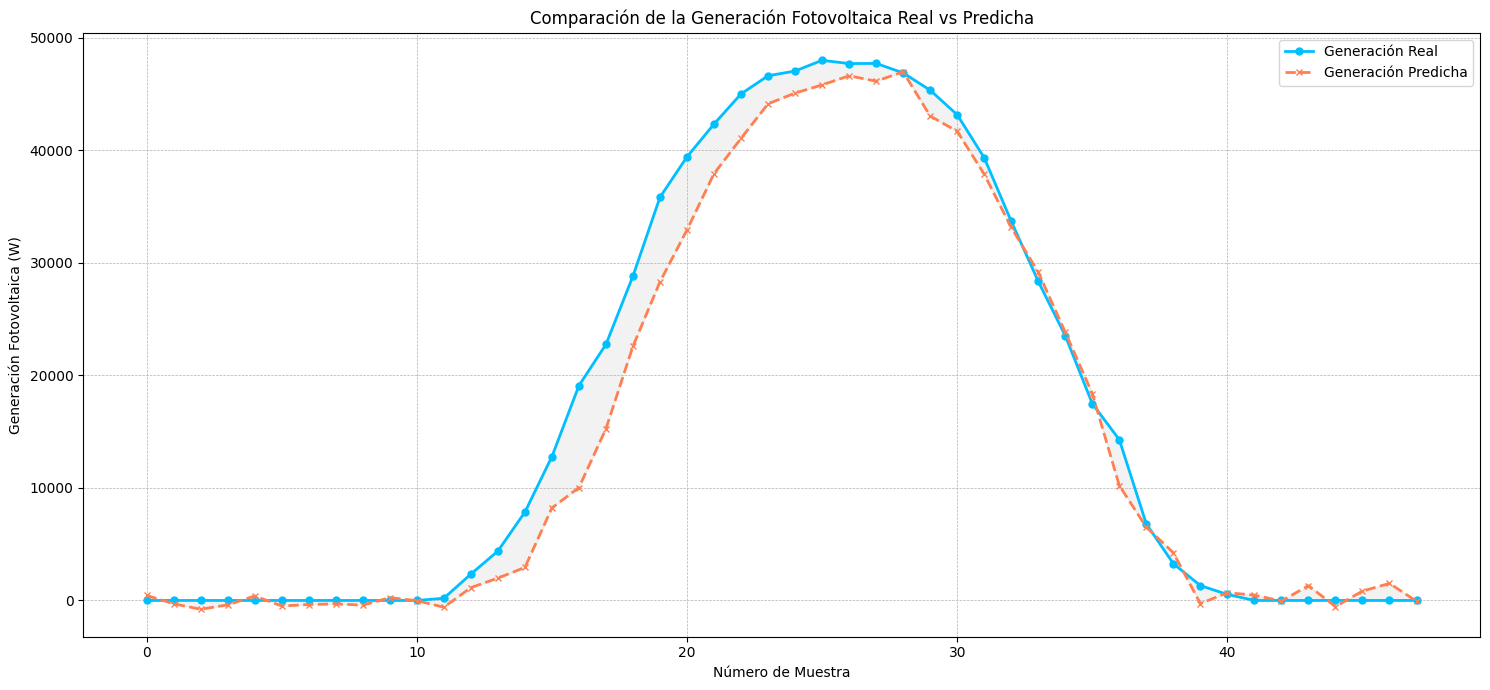

In [ ]:
# Calcular predicciones sobre el set de validación
y_val_pred = predecir(x_val_s, modelo_load, scaler)

# Aplanar y_ts para que coincida con la forma de y_val_pred
y_val_flat = y_val.flatten()
y_val_flat_one_day = y_val_flat[30000:30048]
y_val_pred_one_day = y_val_pred[30000:30048]
num_muestras_one_day = np.arange(48)  # 48 muestras tiene un día

# Graficar la generación fotovoltaica real frente a la predicha para un día
plt.figure(figsize=(15, 7))
plt.plot(num_muestras_one_day, y_val_flat_one_day, label='Generación Real', color='deepskyblue', linewidth=2, marker='o', markersize=5)
plt.plot(num_muestras_one_day, y_val_pred_one_day, label='Generación Predicha', color='coral', linewidth=2, linestyle='--', marker='x', markersize=5)
plt.fill_between(num_muestras_one_day, y_val_flat_one_day, y_val_pred_one_day, color='grey', alpha=0.1)

plt.title('Comparación de la Generación Fotovoltaica Real vs Predicha')
plt.xlabel('Número de Muestra')
plt.ylabel('Generación Fotovoltaica (W)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Al evaluar el impacto de excluir el consumo de energía como variable de entrada en nuestro modelo, considerando que, aunque existe un sistema de antivertido que adapta la generación fotovoltaica al consumo, la relevancia de esta variable podría ser limitada. Los resultados obtenidos son los siguientes:

- RMSE de entrenamiento: Ha aumentado ligeramente de 0.332 a 0.342 al eliminar el consumo como variable.
- RMSE de validación: También se ha incrementado, pasando de 0.360 a 0.362.

Estos cambios en los valores de RMSE, aunque leves, sugieren que el consumo no tiene un papel crucial en la predicción de la generación fotovoltaica bajo las condiciones actuales del modelo. Este resultado podría parecer contrario a la intuición, especialmente dado que los sistemas de antivertido están diseñados para ajustar la generación a las fluctuaciones del consumo. Sin embargo, los datos indican que la eliminación de esta variable no deteriora significativamente la precisión del modelo.


#### 5.3. Ajuste de la Longitud de Entrada del Modelo

Procedemos a cargar nuevamente el dataframe con el objetivo de disponer de todas las variables de entrada necesarias para el entrenamiento de nuestro modelo. En esta iteración, introduciremos la hora del día como una nueva variable predictora, debido a su potencial para mejorar la precisión de las predicciones al reflejar las variaciones diarias significativas.

Adicionalmente, decidimos mantener el consumo de energía como variable de entrada. Aunque análisis previos sugirieron que su influencia en la predicción de la generación fotovoltaica puede no ser decisiva.

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/My Drive/2023_24_TFM_Angel_Marcos_Trujillo/combined_data_definitive.xlsx'
df = pd.read_excel(path, index_col='Fecha y hora')
df

Mounted at /content/gdrive


,Temperatura,Humedad,Velocidad viento,Radiación,PV(W),Load(W)
Fecha y hora,,,,,,
2023-04-04 00:00:00,14.37,85.87,7.33,0.0,0.0,33387.333333
2023-04-04 00:30:00,14.20,91.20,8.10,0.0,0.0,23725.333333
2023-04-04 01:00:00,14.07,92.03,7.90,0.0,0.0,24043.833333
2023-04-04 01:30:00,14.23,91.57,7.40,0.0,0.0,23196.500000
2023-04-04 02:00:00,14.30,86.63,7.13,0.0,0.0,22820.833333
...,...,...,...,...,...,...
2024-04-03 22:00:00,15.17,84.07,2.33,0.0,0.0,35840.500000
2024-04-03 22:30:00,15.03,83.43,2.20,0.0,0.0,36835.500000
2024-04-03 23:00:00,14.63,86.87,2.30,0.0,0.0,31931.833333


In [ ]:
start_date = '2023-09-23'
end_date = '2023-10-05'

# Filtra el DataFrame para excluir el rango de fechas
df = df[(df.index < start_date) | (df.index > end_date)]

In [ ]:
# Extraemos la hora del índice
df['Hora'] = df.index.hour

# Aplicar codificación cíclica
df['Hora_sin'] = np.sin(df['Hora'] * (2. * np.pi / 24))
df['Hora_cos'] = np.cos(df['Hora'] * (2. * np.pi / 24))

# Ahora, el df incluye las nuevas columnas 'Hora_sin' y 'Hora_cos' que
# incluiremos como variables de entrada para el modelo LSTM
print(df.columns)

Index(['Temperatura', 'Radiación', 'PV(W)', 'Load(W)', 'Hora', 'Hora_sin',
       'Hora_cos'],
      dtype='object')


<ipython-input-4-aaebe5cf6208>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hora'] = df.index.hour
<ipython-input-4-aaebe5cf6208>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hora_sin'] = np.sin(df['Hora'] * (2. * np.pi / 24))
<ipython-input-4-aaebe5cf6208>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [ ]:
df.pop('Humedad')
df.pop('Velocidad viento')
df.pop('Hora')
df

,Temperatura,Radiación,PV(W),Load(W),Hora_sin,Hora_cos
Fecha y hora,,,,,,
2023-04-04 00:00:00,14.37,0.0,0.0,33387.333333,0.000000,1.000000
2023-04-04 00:30:00,14.20,0.0,0.0,23725.333333,0.000000,1.000000
2023-04-04 01:00:00,14.07,0.0,0.0,24043.833333,0.258819,0.965926
2023-04-04 01:30:00,14.23,0.0,0.0,23196.500000,0.258819,0.965926
2023-04-04 02:00:00,14.30,0.0,0.0,22820.833333,0.500000,0.866025
...,...,...,...,...,...,...
2024-04-03 22:00:00,15.17,0.0,0.0,35840.500000,-0.500000,0.866025
2024-04-03 22:30:00,15.03,0.0,0.0,36835.500000,-0.500000,0.866025
2024-04-03 23:00:00,14.63,0.0,0.0,31931.833333,-0.258819,0.965926


Creamos el dataset, modificando esta vez los días por meses que son para entreno y para validación en base al input length.

In [ ]:
def crear_dataset_supervisado(dataframe, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.
    '''
    X_train, y_train = [], []  # Listados que contendrán los datos de entrada y salida del modelo para entrenamiento
    X_val, y_val = [], []  # Listados que contendrán los datos de entrada y salida del modelo para validar

    # Generar los arreglos
    for i in range(len(dataframe) - input_length - output_length + 1):
        X_temp = dataframe.iloc[i:(i + input_length), :]  # Tomar las filas correspondientes a las entradas
        y_temp = dataframe.iloc[(i + input_length):(i + input_length + output_length), 2]

        # Extraer la fecha de la última muestra en el conjunto de entrada
        fecha_prediccion = pd.to_datetime(y_temp.index[0])
        dia_mes = fecha_prediccion.day

        if dia_mes <= 21:
            X_train.append(X_temp.values)
            y_train.append(y_temp.values)
        elif dia_mes >= 26:
            X_val.append(X_temp.values)
            y_val.append(y_temp.values)

    # Convertir listas a arreglos de NumPy
    X_train = np.array(X_train)
    y_train = np.array(y_train).reshape(-1, output_length, 1)  # Reshape para multi-step output
    X_val = np.array(X_val)
    y_val = np.array(y_val).reshape(-1, output_length, 1)  # Reshape para multi-step output

    return X_train, y_train, X_val, y_val

##### 5.3.1. Ajuste 1: Input length de 1 día

In [ ]:
INPUT_LENGTH = 48  # Número de pasos de tiempo que el modelo utilizará para hacer predicciones
OUTPUT_LENGTH = 48  # Número de pasos de tiempo a predecir
x_tr, y_tr, x_val, y_val = crear_dataset_supervisado(df, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
print(f'Tamaño del set de entrenamiento: {x_tr.shape}')
print(f'Tamaño del set de validación: {x_val.shape}')

Tamaño del set de entrenamiento: (12385, 48, 6)
Tamaño del set de validación: (2928, 48, 6)


In [ ]:
# Escalamiento del dataset con la función escalar_dataset

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_val': x_val, 'y_val': y_val,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'PV(W)' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_val_s, y_val_s = data_s['x_val_s'], data_s['y_val_s']

In [ ]:
modelo_inp1, historia_inp1 = entrenar_modelo(
    x_train=x_tr_s,
    y_train=y_tr_s,
    x_val=x_val_s,
    y_val=y_val_s,
    optimizer='adam',
    learning_rate=5e-4,
    n_units=128,
    input_shape=(x_tr_s.shape[1], x_tr_s.shape[2]),
    epochs=60,
    batch_size=256
)

Epoch 1/60
47/47 - 3s - loss: 0.7435 - val_loss: 0.5027 - 3s/epoch - 64ms/step
Epoch 2/60
47/47 - 0s - loss: 0.4701 - val_loss: 0.4303 - 327ms/epoch - 7ms/step
Epoch 3/60
47/47 - 0s - loss: 0.4316 - val_loss: 0.4087 - 287ms/epoch - 6ms/step
Epoch 4/60
47/47 - 0s - loss: 0.4111 - val_loss: 0.3910 - 319ms/epoch - 7ms/step
Epoch 5/60
47/47 - 0s - loss: 0.4011 - val_loss: 0.3866 - 325ms/epoch - 7ms/step
Epoch 6/60
47/47 - 0s - loss: 0.3960 - val_loss: 0.3818 - 293ms/epoch - 6ms/step
Epoch 7/60
47/47 - 0s - loss: 0.3928 - val_loss: 0.3793 - 297ms/epoch - 6ms/step
Epoch 8/60
47/47 - 0s - loss: 0.3879 - val_loss: 0.3780 - 323ms/epoch - 7ms/step
Epoch 9/60
47/47 - 0s - loss: 0.3868 - val_loss: 0.3776 - 297ms/epoch - 6ms/step
Epoch 10/60
47/47 - 0s - loss: 0.3831 - val_loss: 0.3834 - 324ms/epoch - 7ms/step
Epoch 11/60
47/47 - 0s - loss: 0.3807 - val_loss: 0.3865 - 318ms/epoch - 7ms/step
Epoch 12/60
47/47 - 0s - loss: 0.3777 - val_loss: 0.3849 - 328ms/epoch - 7ms/step
Epoch 13/60
47/47 - 0s - lo

**Evaluación del modelo**

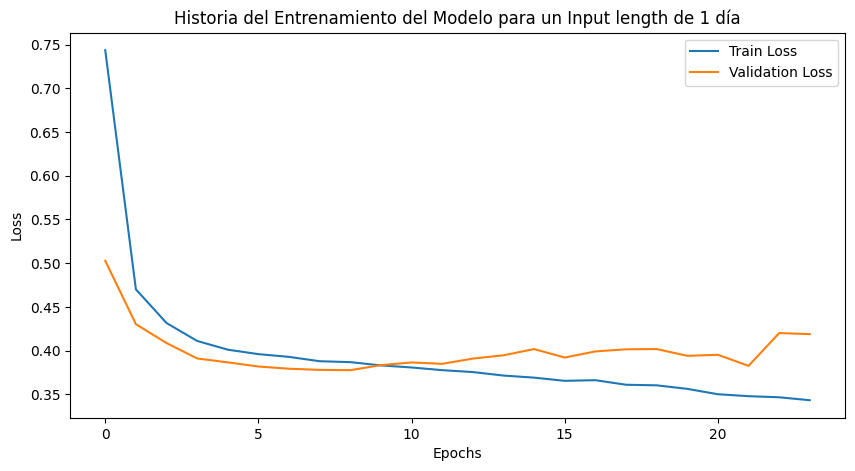

In [ ]:
import matplotlib.pyplot as plt

# Visualizar la historia de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(historia_inp1.history['loss'], label='Train Loss')
plt.plot(historia_inp1.history['val_loss'], label='Validation Loss')
plt.title('Historia del Entrenamiento del Modelo para un Input length de 1 día')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Cálculo de rmses para train y val
rmse_tr = modelo_inp1.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_val = modelo_inp1.evaluate(x=x_val_s, y=y_val_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños - Input length de 1 día:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE validation:\t {rmse_val:.3f}')

Comparativo desempeños - Input length de 1 día:
  RMSE train:	 0.348
  RMSE validation:	 0.361


##### 5.3.2. Ajuste 2: Input length de 4 días

In [ ]:
INPUT_LENGTH = 192  # Número de pasos de tiempo que el modelo utilizará para hacer predicciones
OUTPUT_LENGTH = 48  # Número de pasos de tiempo a predecir
x_tr, y_tr, x_val, y_val = crear_dataset_supervisado(df, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
print(f'Tamaño del set de entrenamiento: {x_tr.shape}')
print(f'Tamaño del set de validación: {x_val.shape}')

Tamaño del set de entrenamiento: (11665, 192, 6)
Tamaño del set de validación: (2928, 192, 6)


In [ ]:
# Escalamiento del dataset con la función escalar_dataset

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_val': x_val, 'y_val': y_val,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'PV(W)' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_val_s, y_val_s = data_s['x_val_s'], data_s['y_val_s']

In [ ]:
modelo_inp2, historia_inp2 = entrenar_modelo(
    x_train=x_tr_s,
    y_train=y_tr_s,
    x_val=x_val_s,
    y_val=y_val_s,
    optimizer='adam',
    learning_rate=5e-4,
    n_units=128,
    input_shape=(x_tr_s.shape[1], x_tr_s.shape[2]),
    epochs=60,
    batch_size=256
)

Epoch 1/60
46/46 - 3s - loss: 0.7525 - val_loss: 0.5145 - 3s/epoch - 65ms/step
Epoch 2/60
46/46 - 1s - loss: 0.4773 - val_loss: 0.4410 - 774ms/epoch - 17ms/step
Epoch 3/60
46/46 - 1s - loss: 0.4406 - val_loss: 0.4114 - 775ms/epoch - 17ms/step
Epoch 4/60
46/46 - 1s - loss: 0.4181 - val_loss: 0.3913 - 786ms/epoch - 17ms/step
Epoch 5/60
46/46 - 1s - loss: 0.4008 - val_loss: 0.3835 - 869ms/epoch - 19ms/step
Epoch 6/60
46/46 - 1s - loss: 0.3931 - val_loss: 0.3779 - 836ms/epoch - 18ms/step
Epoch 7/60
46/46 - 1s - loss: 0.3882 - val_loss: 0.3830 - 808ms/epoch - 18ms/step
Epoch 8/60
46/46 - 1s - loss: 0.3843 - val_loss: 0.3822 - 897ms/epoch - 19ms/step
Epoch 9/60
46/46 - 1s - loss: 0.3803 - val_loss: 0.3948 - 793ms/epoch - 17ms/step
Epoch 10/60
46/46 - 1s - loss: 0.3764 - val_loss: 0.3973 - 777ms/epoch - 17ms/step
Epoch 11/60
46/46 - 1s - loss: 0.3729 - val_loss: 0.4077 - 828ms/epoch - 18ms/step
Epoch 12/60
46/46 - 1s - loss: 0.3694 - val_loss: 0.4110 - 808ms/epoch - 18ms/step
Epoch 13/60
46/4

**Evaluación del modelo**

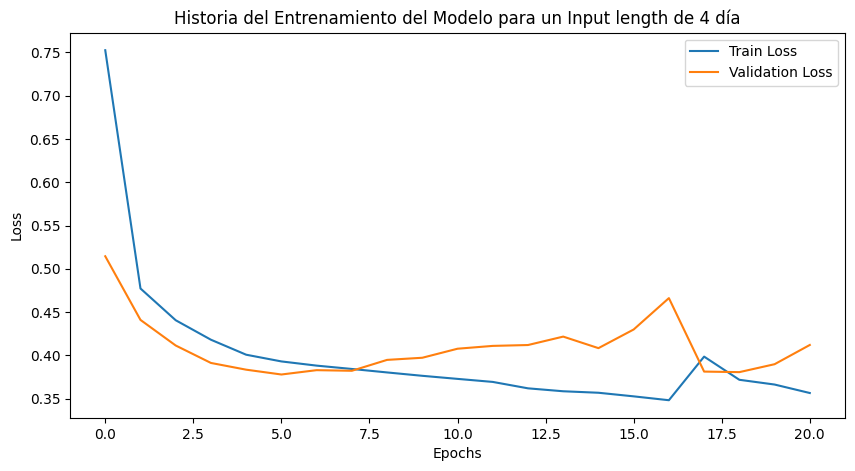

In [ ]:
# Visualizar la historia de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(historia_inp2.history['loss'], label='Train Loss')
plt.plot(historia_inp2.history['val_loss'], label='Validation Loss')
plt.title('Historia del Entrenamiento del Modelo para un Input length de 4 día')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Cálculo de rmses para train y val
rmse_tr = modelo_inp2.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_val = modelo_inp2.evaluate(x=x_val_s, y=y_val_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños - Input length de 4 día:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE validation:\t {rmse_val:.3f}')

Comparativo desempeños - Input length de 4 día:
  RMSE train:	 0.355
  RMSE validation:	 0.362


##### 5.3.3. Justificación

Tras llevar a cabo experimentos con tres diferentes configuraciones de input length —1 día, 3 días y 4 días— para nuestro modelo de predicción, hemos observado que las variaciones en los valores de RMSE son mínimas y consistentes a través de estas configuraciones. A continuación, se detallan los resultados:
- Input Length de 1 día:
  - RMSE train: 0.348
  - RMSE validation: 0.361
- Input Length de 3 días:
  - RMSE train: 0.341
  - RMSE validation: 0.361
- Input Length de 4 días:
  - RMSE train: 0.355
  - RMSE validation: 0.362

La variación en los resultados muestra que el modelo mantiene un desempeño consistente en términos de RMSE a través de diferentes configuraciones de input length, con pequeñas diferencias en los valores obtenidos, siendo bastantes similares en general. Específicamente, el input length de 3 días proporciona los resultados más óptimos tanto en entrenamiento como en validación.

No obstante, si bien el input length de 3 días ofrece el mejor equilibrio general entre precisión y recursos computacionales, configuraciones más cortas pueden ser preferibles para prototipado rápido o cuando las limitaciones de tiempo son críticas cómo es el caso del input length de 1 día.

## 6. Predicciones para diferentes días con el mejor modelo y configuración

In [ ]:
modelo, historia = entrenar_modelo(
    x_train=x_tr_s,
    y_train=y_tr_s,
    x_val=x_val_s,
    y_val=y_val_s,
    optimizer='adam',
    learning_rate=5e-4,
    n_units=128,
    input_shape=(x_tr_s.shape[1], x_tr_s.shape[2]),
    epochs=60,
    batch_size=256
)

Epoch 1/60
49/49 - 6s - loss: 0.7556 - val_loss: 0.5056 - 6s/epoch - 132ms/step
Epoch 2/60
49/49 - 1s - loss: 0.4811 - val_loss: 0.4365 - 727ms/epoch - 15ms/step
Epoch 3/60
49/49 - 1s - loss: 0.4402 - val_loss: 0.4233 - 685ms/epoch - 14ms/step
Epoch 4/60
49/49 - 1s - loss: 0.4202 - val_loss: 0.4205 - 670ms/epoch - 14ms/step
Epoch 5/60
49/49 - 1s - loss: 0.4125 - val_loss: 0.3871 - 761ms/epoch - 16ms/step
Epoch 6/60
49/49 - 1s - loss: 0.3996 - val_loss: 0.3998 - 648ms/epoch - 13ms/step
Epoch 7/60
49/49 - 1s - loss: 0.3998 - val_loss: 0.3980 - 622ms/epoch - 13ms/step
Epoch 8/60
49/49 - 1s - loss: 0.3961 - val_loss: 0.3932 - 624ms/epoch - 13ms/step
Epoch 9/60
49/49 - 1s - loss: 0.3930 - val_loss: 0.3809 - 630ms/epoch - 13ms/step
Epoch 10/60
49/49 - 1s - loss: 0.3899 - val_loss: 0.3844 - 615ms/epoch - 13ms/step
Epoch 11/60
49/49 - 1s - loss: 0.3895 - val_loss: 0.3848 - 616ms/epoch - 13ms/step
Epoch 12/60
49/49 - 1s - loss: 0.3871 - val_loss: 0.3943 - 616ms/epoch - 13ms/step
Epoch 13/60
49/

In [ ]:
# Cálculo de rmses para train y val
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_val = modelo.evaluate(x=x_val_s, y=y_val_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE validation:\t {rmse_val:.3f}')

Comparativo desempeños:
  RMSE train:	 0.354
  RMSE validation:	 0.363


In [ ]:
# Guardar el modelo completo
modelo.save('modelo_prediccion.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


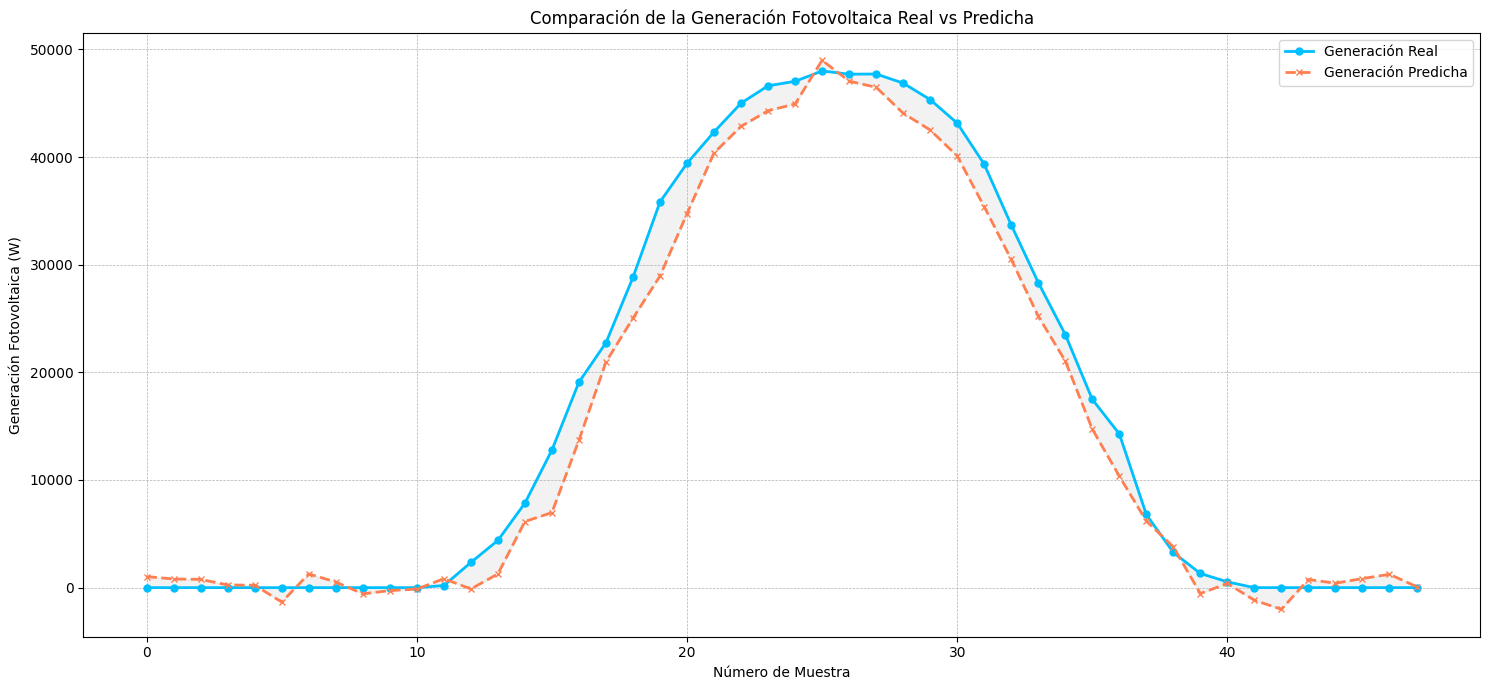

In [ ]:
import matplotlib.pyplot as plt
# Calcular predicciones sobre el set de validación
y_val_pred = predecir(x_val_s, modelo, scaler)

# Aplanar y_ts para que coincida con la forma de y_val_pred
y_val_flat = y_val.flatten()
y_val_flat_one_day = y_val_flat[30000:30048]
y_val_pred_one_day = y_val_pred[30000:30048]
num_muestras_one_day = np.arange(48)  # 48 muestras tiene un día

# Graficar la generación fotovoltaica real frente a la predicha para un día
plt.figure(figsize=(15, 7))
plt.plot(num_muestras_one_day, y_val_flat_one_day, label='Generación Real', color='deepskyblue', linewidth=2, marker='o', markersize=5)
plt.plot(num_muestras_one_day, y_val_pred_one_day, label='Generación Predicha', color='coral', linewidth=2, linestyle='--', marker='x', markersize=5)
plt.fill_between(num_muestras_one_day, y_val_flat_one_day, y_val_pred_one_day, color='grey', alpha=0.1)

plt.title('Comparación de la Generación Fotovoltaica Real vs Predicha')
plt.xlabel('Número de Muestra')
plt.ylabel('Generación Fotovoltaica (W)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

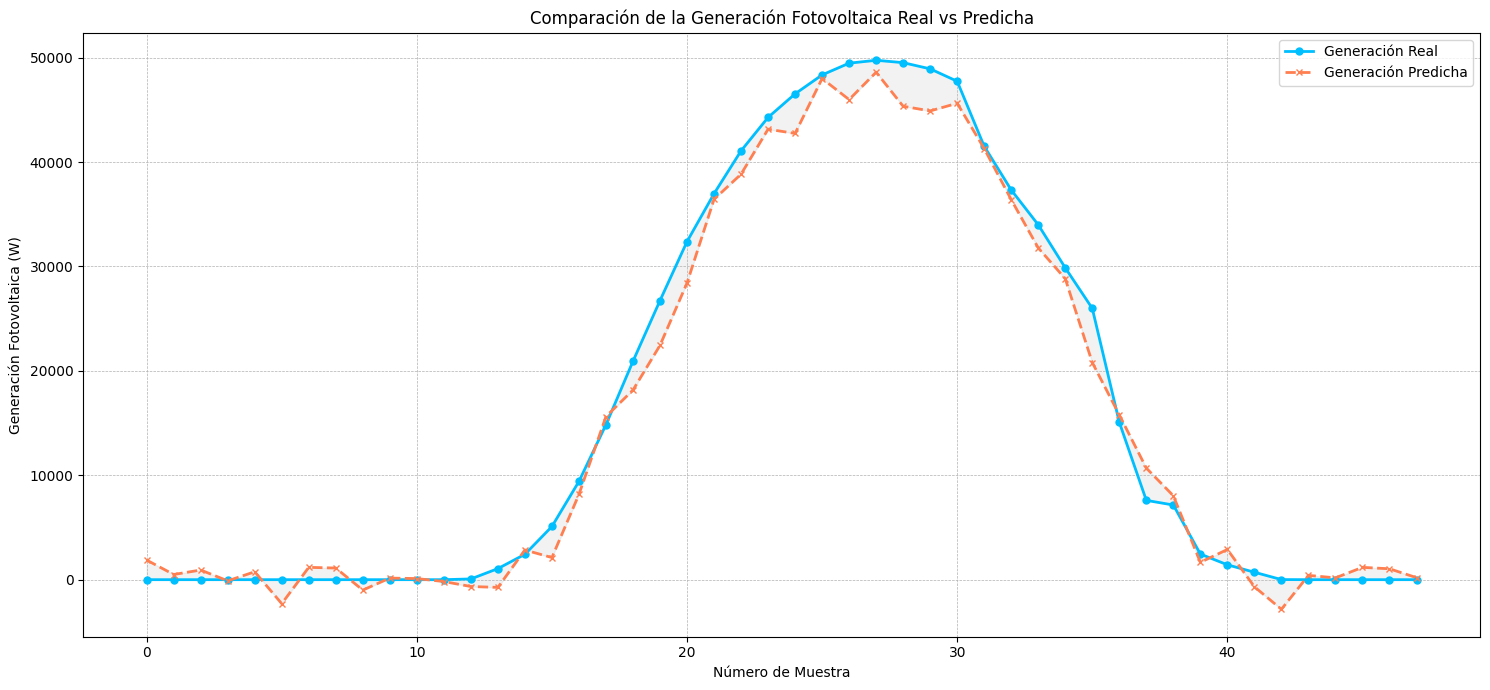

In [ ]:
# Aplanar y_ts para que coincida con la forma de y_val_pred
y_val_flat = y_val.flatten()

y_val_flat_one_day = y_val_flat[32256:32304]
y_val_pred_one_day = y_val_pred[32256:32304]
num_muestras_one_day = np.arange(48)  # 48 muestras tiene un día

# Graficar la generación fotovoltaica real frente a la predicha para un día
plt.figure(figsize=(15, 7))
plt.plot(num_muestras_one_day, y_val_flat_one_day, label='Generación Real', color='deepskyblue', linewidth=2, marker='o', markersize=5)
plt.plot(num_muestras_one_day, y_val_pred_one_day, label='Generación Predicha', color='coral', linewidth=2, linestyle='--', marker='x', markersize=5)
plt.fill_between(num_muestras_one_day, y_val_flat_one_day, y_val_pred_one_day, color='grey', alpha=0.1)

plt.title('Comparación de la Generación Fotovoltaica Real vs Predicha')
plt.xlabel('Número de Muestra')
plt.ylabel('Generación Fotovoltaica (W)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

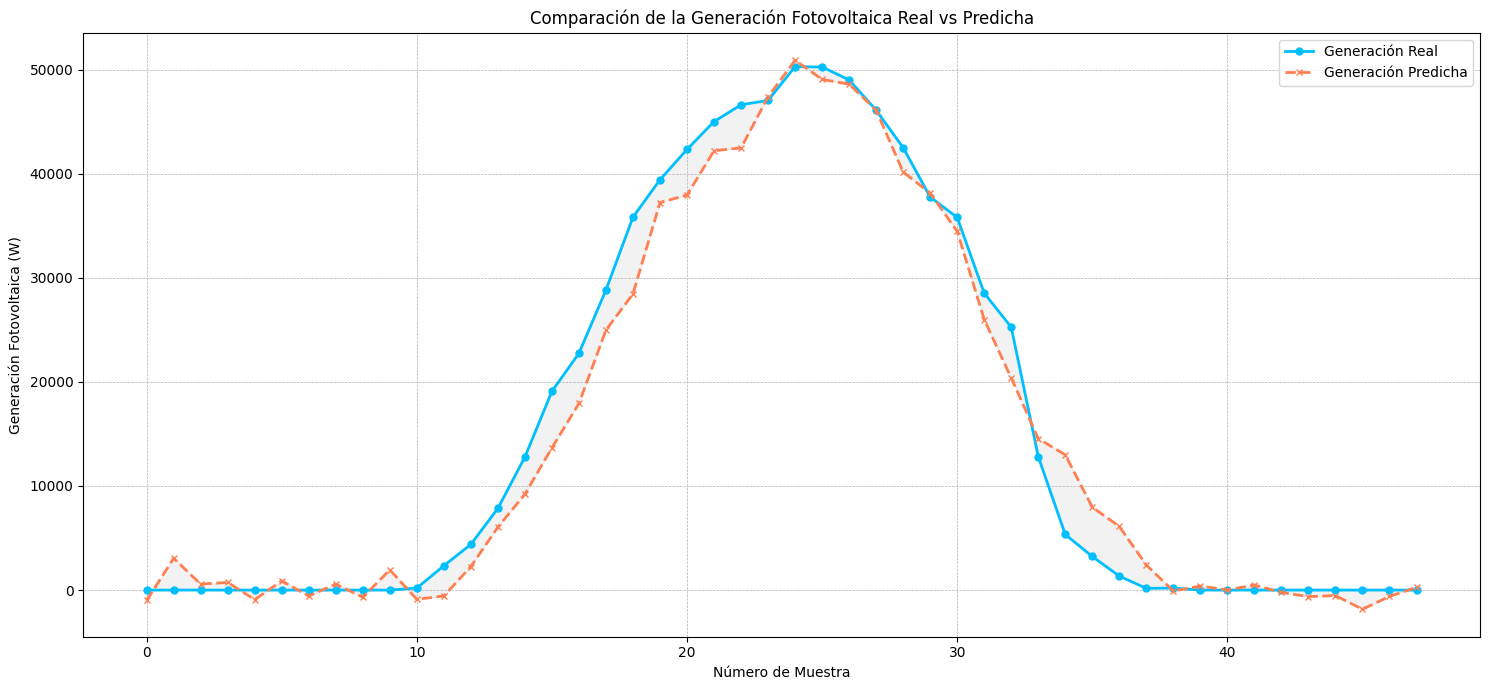

In [ ]:
# Aplanar y_ts para que coincida con la forma de y_val_pred
y_val_flat = y_val.flatten()

y_val_flat_one_day = y_val_flat[28920:28968]
y_val_pred_one_day = y_val_pred[28920:28968]
num_muestras_one_day = np.arange(48)  # 48 muestras tiene un día

# Graficar la generación fotovoltaica real frente a la predicha para un día
plt.figure(figsize=(15, 7))
plt.plot(num_muestras_one_day, y_val_flat_one_day, label='Generación Real', color='deepskyblue', linewidth=2, marker='o', markersize=5)
plt.plot(num_muestras_one_day, y_val_pred_one_day, label='Generación Predicha', color='coral', linewidth=2, linestyle='--', marker='x', markersize=5)
plt.fill_between(num_muestras_one_day, y_val_flat_one_day, y_val_pred_one_day, color='grey', alpha=0.1)

plt.title('Comparación de la Generación Fotovoltaica Real vs Predicha')
plt.xlabel('Número de Muestra')
plt.ylabel('Generación Fotovoltaica (W)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

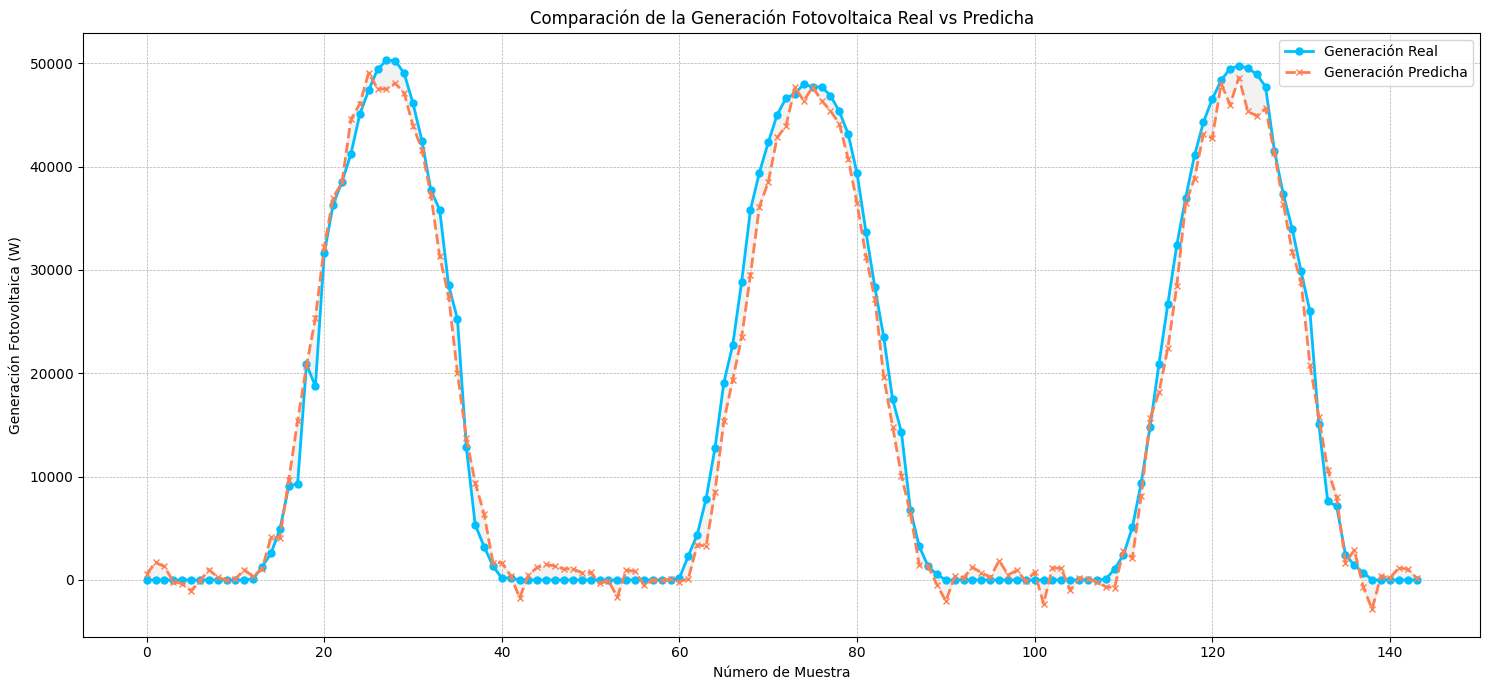

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calcular_indices_dia(base, intervalos):
    return np.concatenate([np.arange(base + i * 2304, base + i * 2304 + 48) for i in intervalos])

# Calcular predicciones sobre el set de validación
y_val_pred = predecir(x_val_s, modelo, scaler)
y_val_flat = y_val.flatten()  # Aplanar y_ts para que coincida con la forma de y_val_pred

# Calcular índices para un día específico:
indices_un_dia = calcular_indices_dia(0, [12, 13, 14])

# Extraer los datos para un día
y_val_flat_one_day = y_val_flat[indices_un_dia]
y_val_pred_one_day = y_val_pred[indices_un_dia]
num_muestras_one_day = np.arange(144)  # 48 muestras por día

# Graficar la generación fotovoltaica real frente a la predicha para un día
plt.figure(figsize=(15, 7))
plt.plot(num_muestras_one_day, y_val_flat_one_day, label='Generación Real', color='deepskyblue', linewidth=2, marker='o', markersize=5)
plt.plot(num_muestras_one_day, y_val_pred_one_day, label='Generación Predicha', color='coral', linewidth=2, linestyle='--', marker='x', markersize=5)
plt.fill_between(num_muestras_one_day, y_val_flat_one_day, y_val_pred_one_day, color='grey', alpha=0.1)

plt.title('Comparación de la Generación Fotovoltaica Real vs Predicha')
plt.xlabel('Número de Muestra')
plt.ylabel('Generación Fotovoltaica (W)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


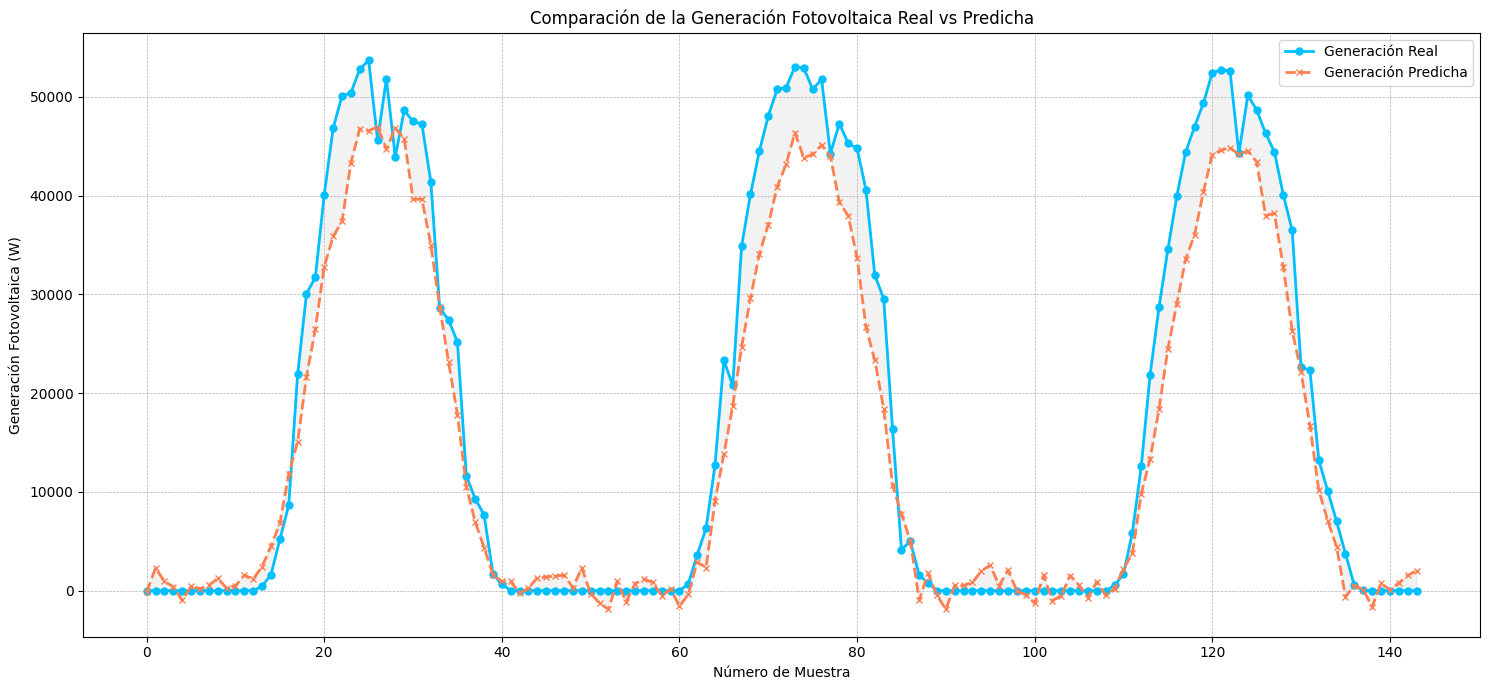

In [ ]:
# Calcular índices para un día específico:
indices_un_dia = calcular_indices_dia(0, [0, 1, 2])

# Extraer los datos para un día
y_val_flat_one_day = y_val_flat[indices_un_dia]
y_val_pred_one_day = y_val_pred[indices_un_dia]
num_muestras_one_day = np.arange(144)  # 48 muestras por día

# Graficar la generación fotovoltaica real frente a la predicha para un día
plt.figure(figsize=(15, 7))
plt.plot(num_muestras_one_day, y_val_flat_one_day, label='Generación Real', color='deepskyblue', linewidth=2, marker='o', markersize=5)
plt.plot(num_muestras_one_day, y_val_pred_one_day, label='Generación Predicha', color='coral', linewidth=2, linestyle='--', marker='x', markersize=5)
plt.fill_between(num_muestras_one_day, y_val_flat_one_day, y_val_pred_one_day, color='grey', alpha=0.1)

plt.title('Comparación de la Generación Fotovoltaica Real vs Predicha')
plt.xlabel('Número de Muestra')
plt.ylabel('Generación Fotovoltaica (W)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
